In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [ ]:

plt.rcParams['figure.dpi'] = 200
sns.set(rc={'axes.facecolor': '#faded9'}, style='darkgrid')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/heart (4).csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [ ]:
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


features_to_convert = [feature for feature in df.columns if feature not in continuous_features]
df[features_to_convert] = df[features_to_convert].astype('object')

df.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target       object
dtype: object

In [ ]:

df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [ ]:

df.describe(include='object')

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,303,303,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,2,0,2,1
freq,207,143,258,152,204,142,175,166,165


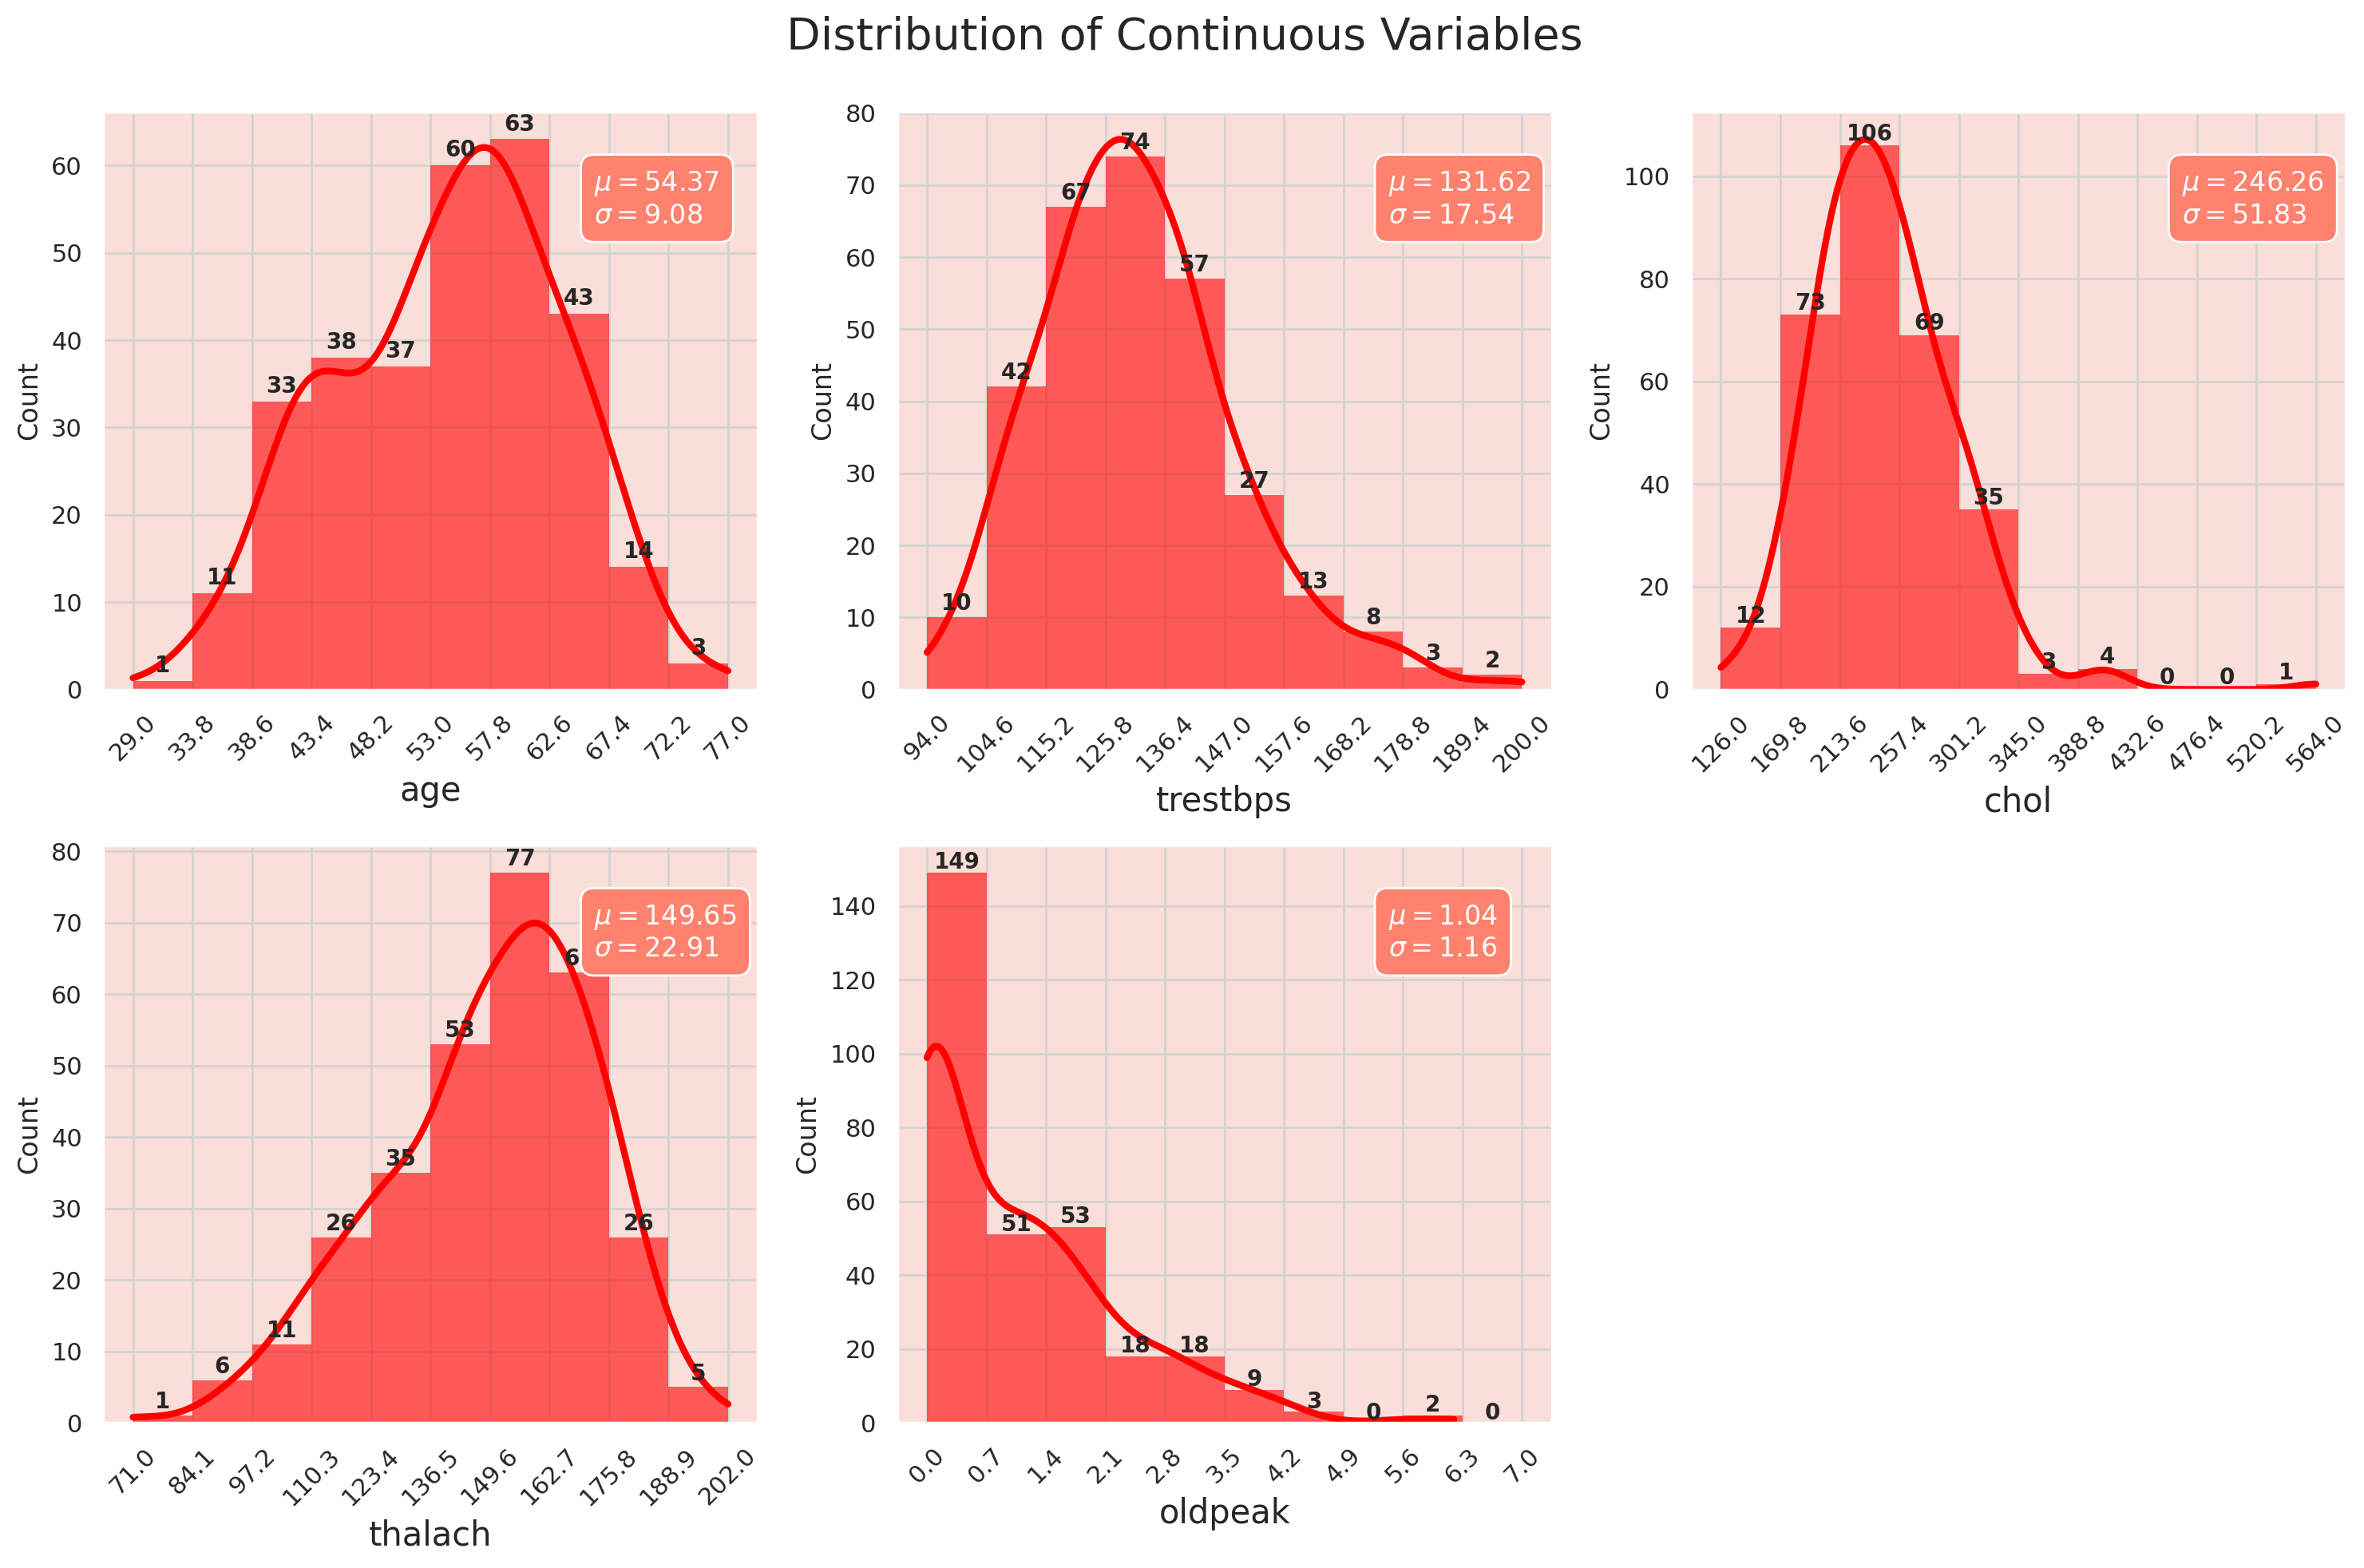

In [ ]:

df_continuous = df[continuous_features]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, col in enumerate(df_continuous.columns):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(df_continuous[col],
                                     range=(np.floor(df_continuous[col].min()), np.ceil(df_continuous[col].max())))

    graph = sns.histplot(data=df_continuous, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='red', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')

    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")

    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_continuous[col].mean(),
        r'$\sigma=%.2f$' % df_continuous[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='white', bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5))

ax[1,2].axis('off')
plt.suptitle('Distribution of Continuous Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [ ]:
# Filter out categorical features for the univariate analysis
categorical_features = df.columns.difference(continuous_features)
df_categorical = df[categorical_features]

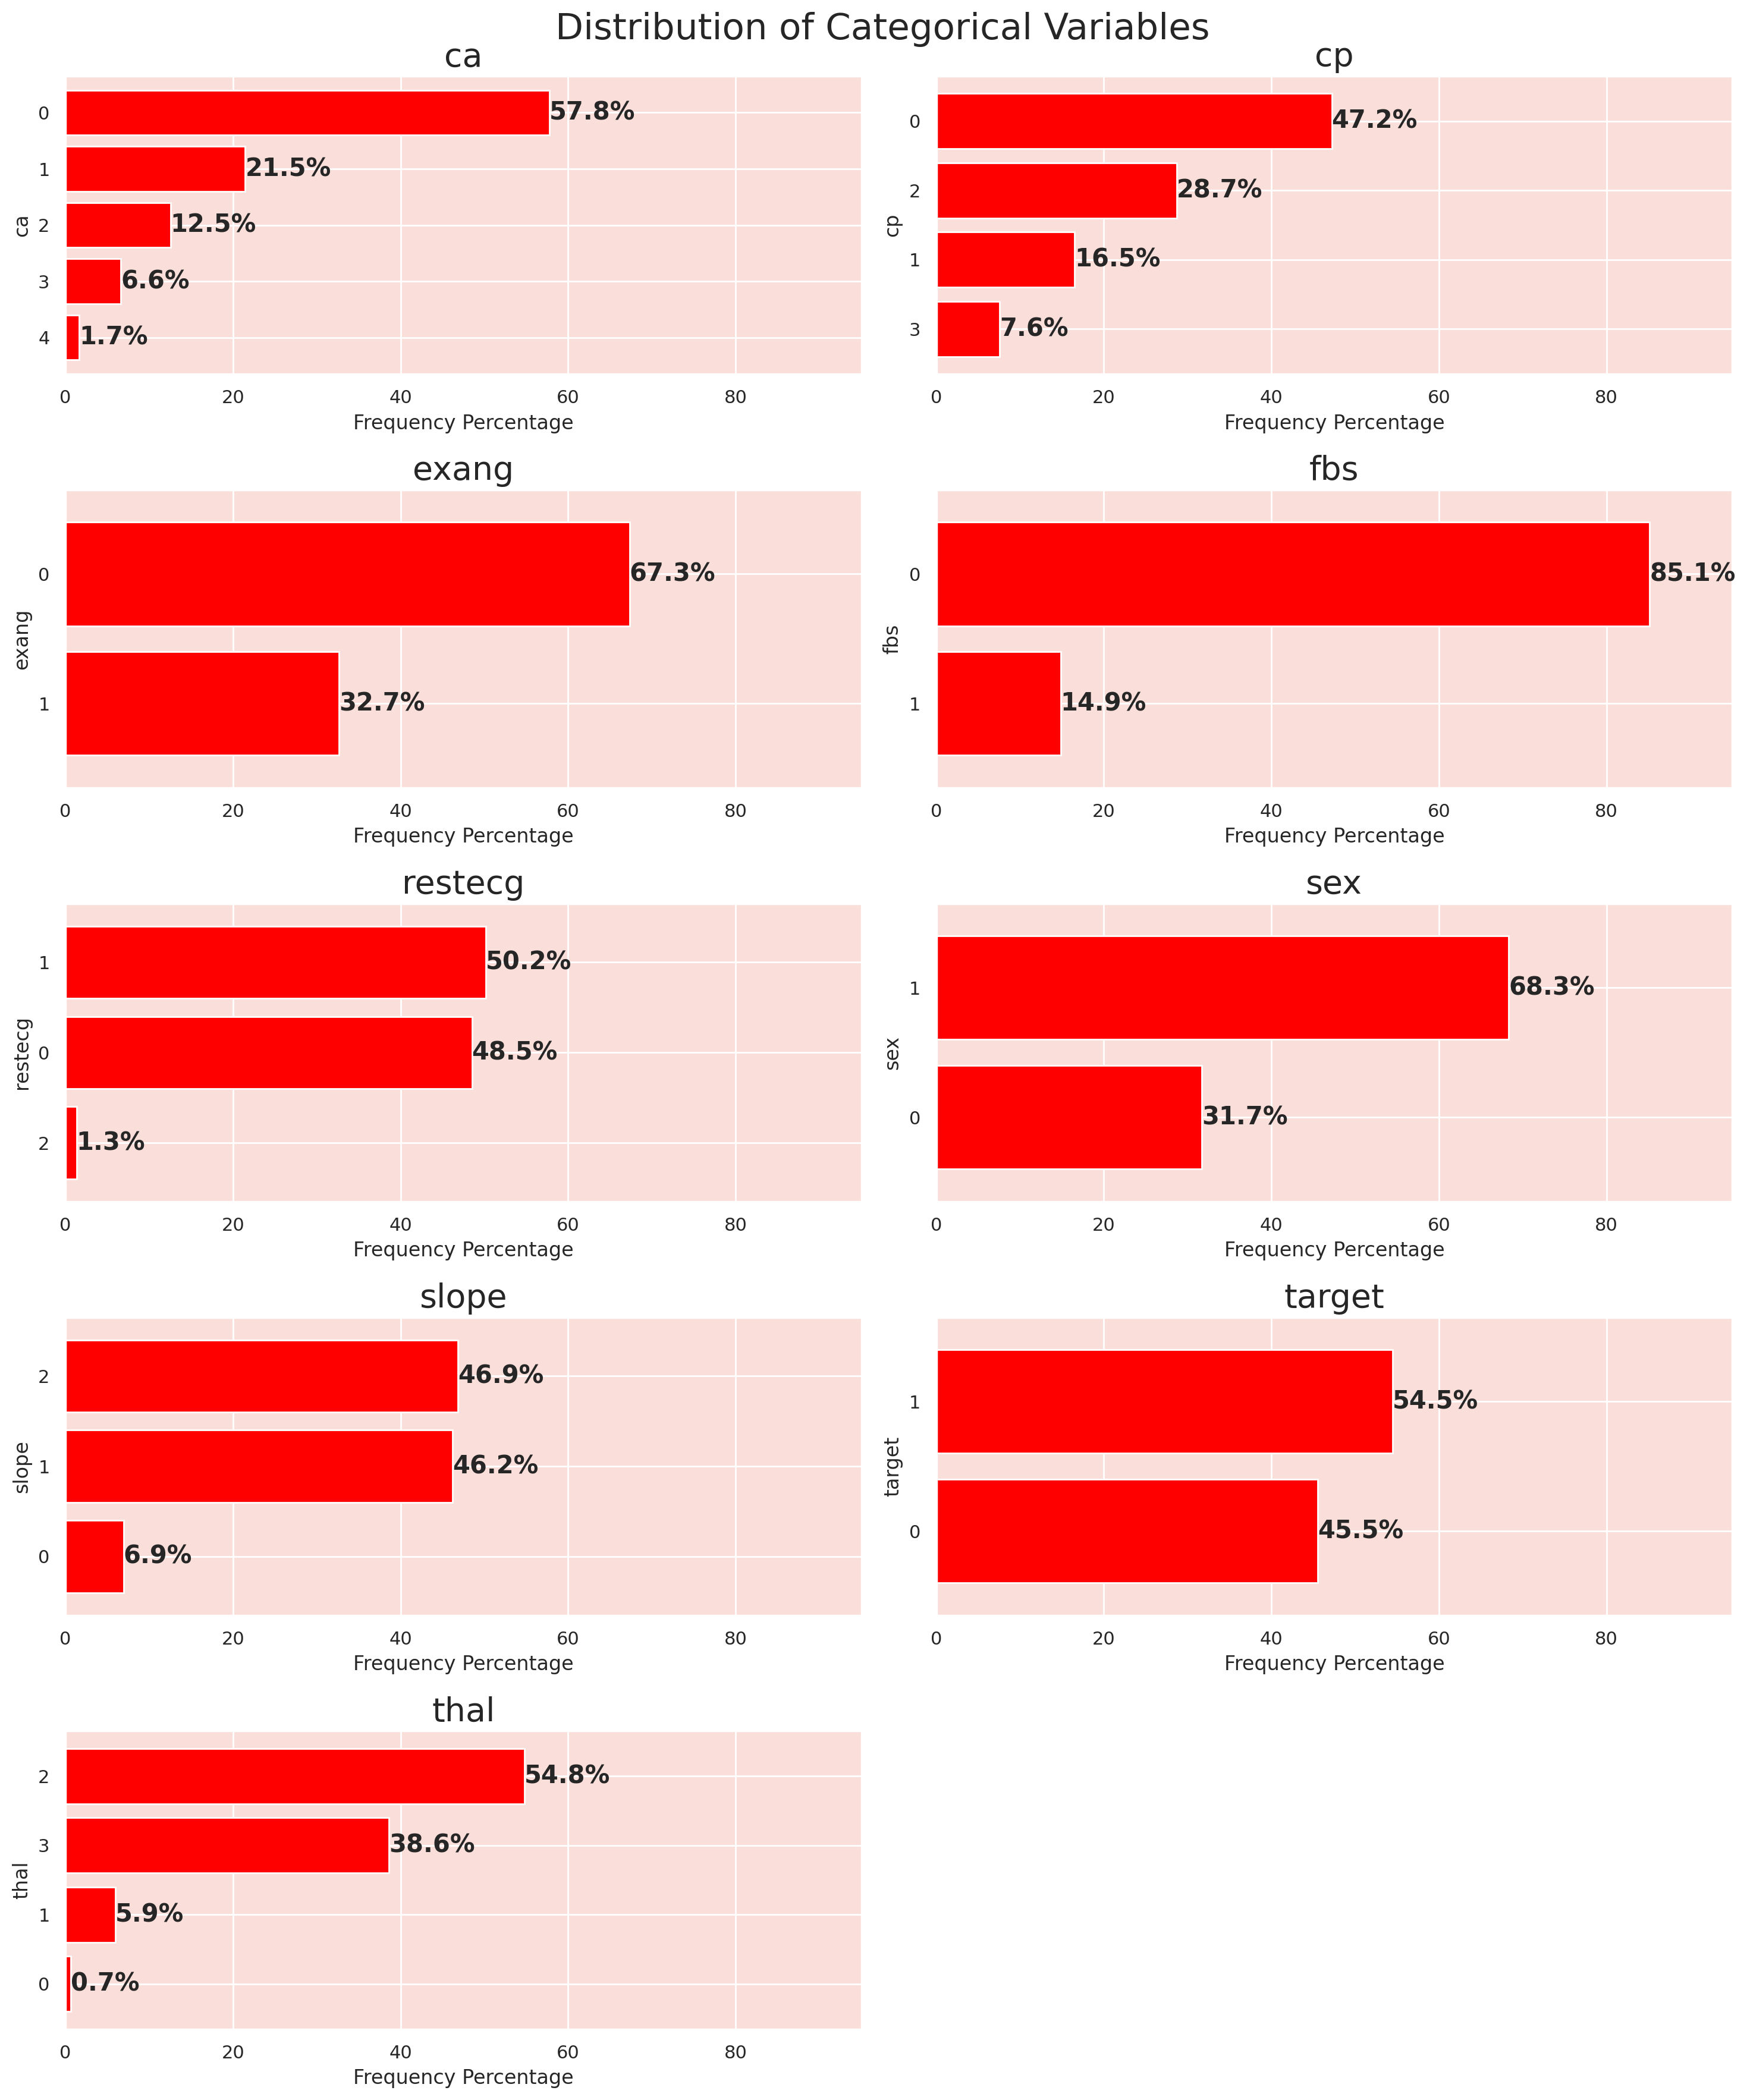

In [ ]:

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))
for i, col in enumerate(categorical_features):
    row = i // 2
    col_idx = i % 2

    value_counts = df[col].value_counts(normalize=True).mul(100).sort_values()

    value_counts.plot(kind='barh', ax=ax[row, col_idx], width=0.8, color='red')

    for index, value in enumerate(value_counts):
        ax[row, col_idx].text(value, index, str(round(value, 1)) + '%', fontsize=15, weight='bold', va='center')

    ax[row, col_idx].set_xlim([0, 95])
    ax[row, col_idx].set_xlabel('Frequency Percentage', fontsize=12)
    ax[row, col_idx].set_title(f'{col}', fontsize=20)

ax[4,1].axis('off')
plt.suptitle('Distribution of Categorical Variables', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

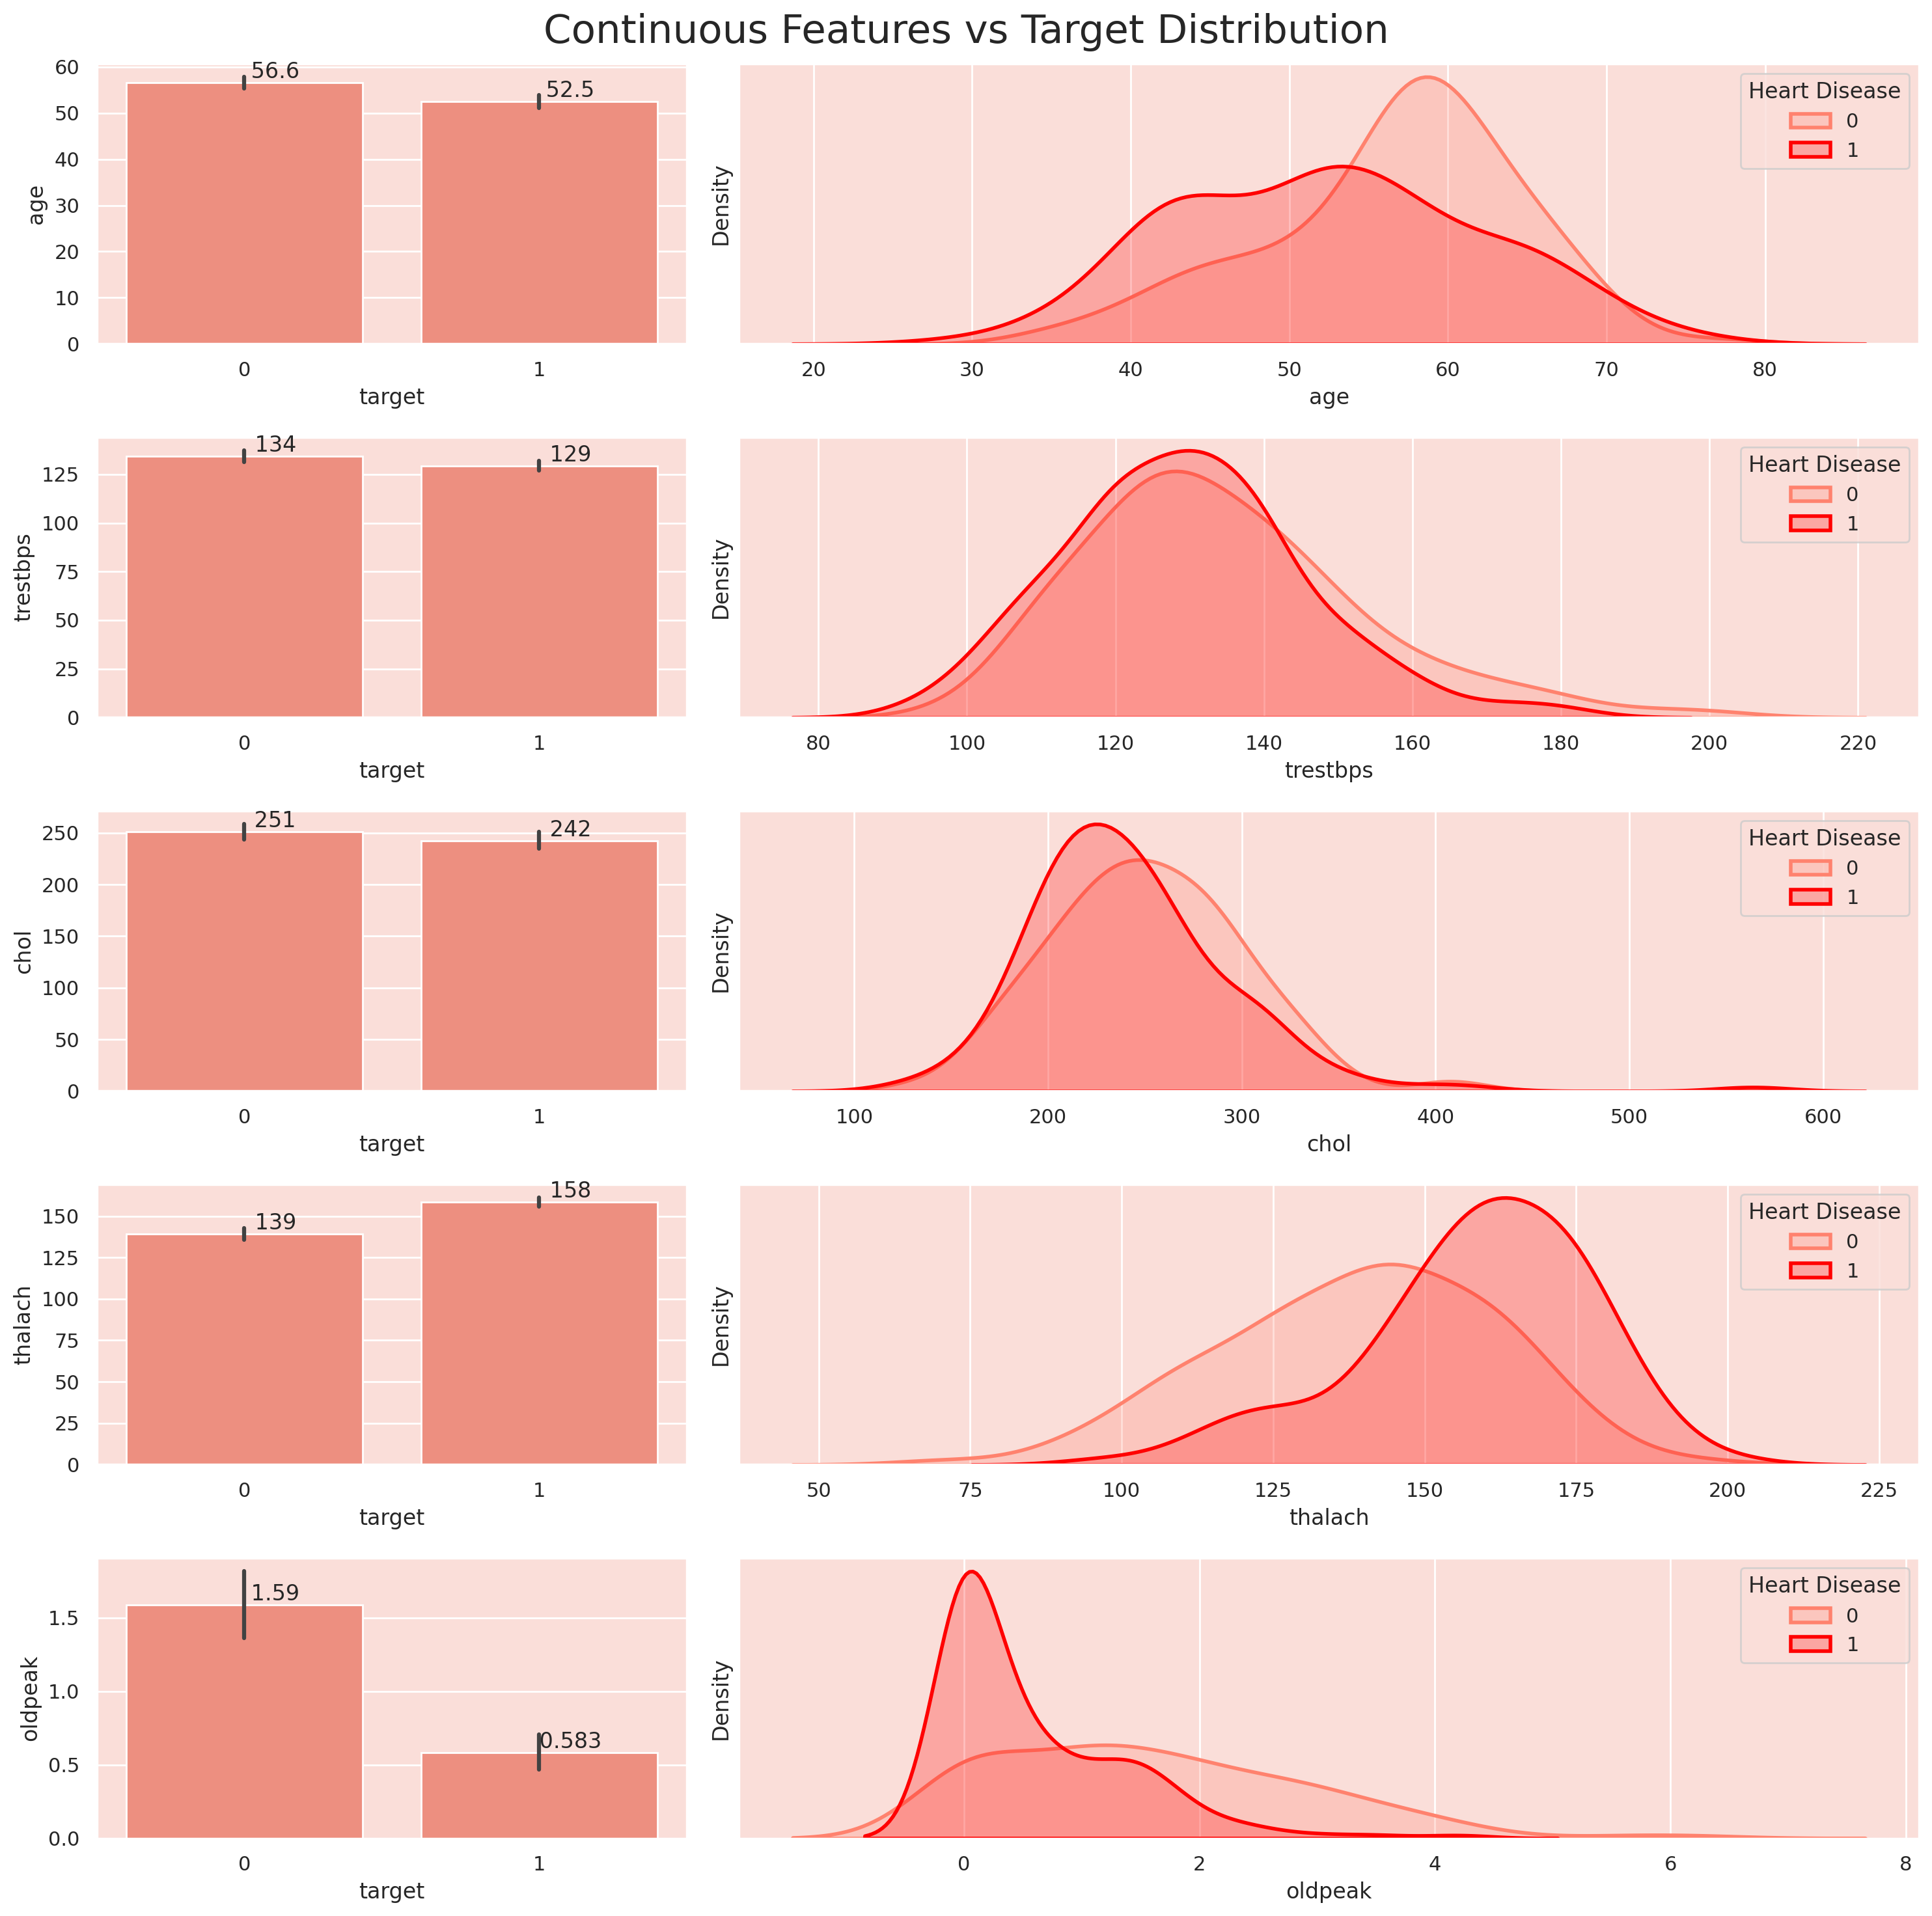

In [ ]:

sns.set_palette(['#ff826e', 'red'])

fig, ax = plt.subplots(len(continuous_features), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})

for i, col in enumerate(continuous_features):

    graph = sns.barplot(data=df, x="target", y=col, ax=ax[i,0])

    sns.kdeplot(data=df[df["target"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["target"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Heart Disease', loc='upper right')


    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')


plt.suptitle('Continuous Features vs Target Distribution', fontsize=22)
plt.tight_layout()
plt.show()

In [ ]:

categorical_features = [feature for feature in categorical_features if feature != 'target']

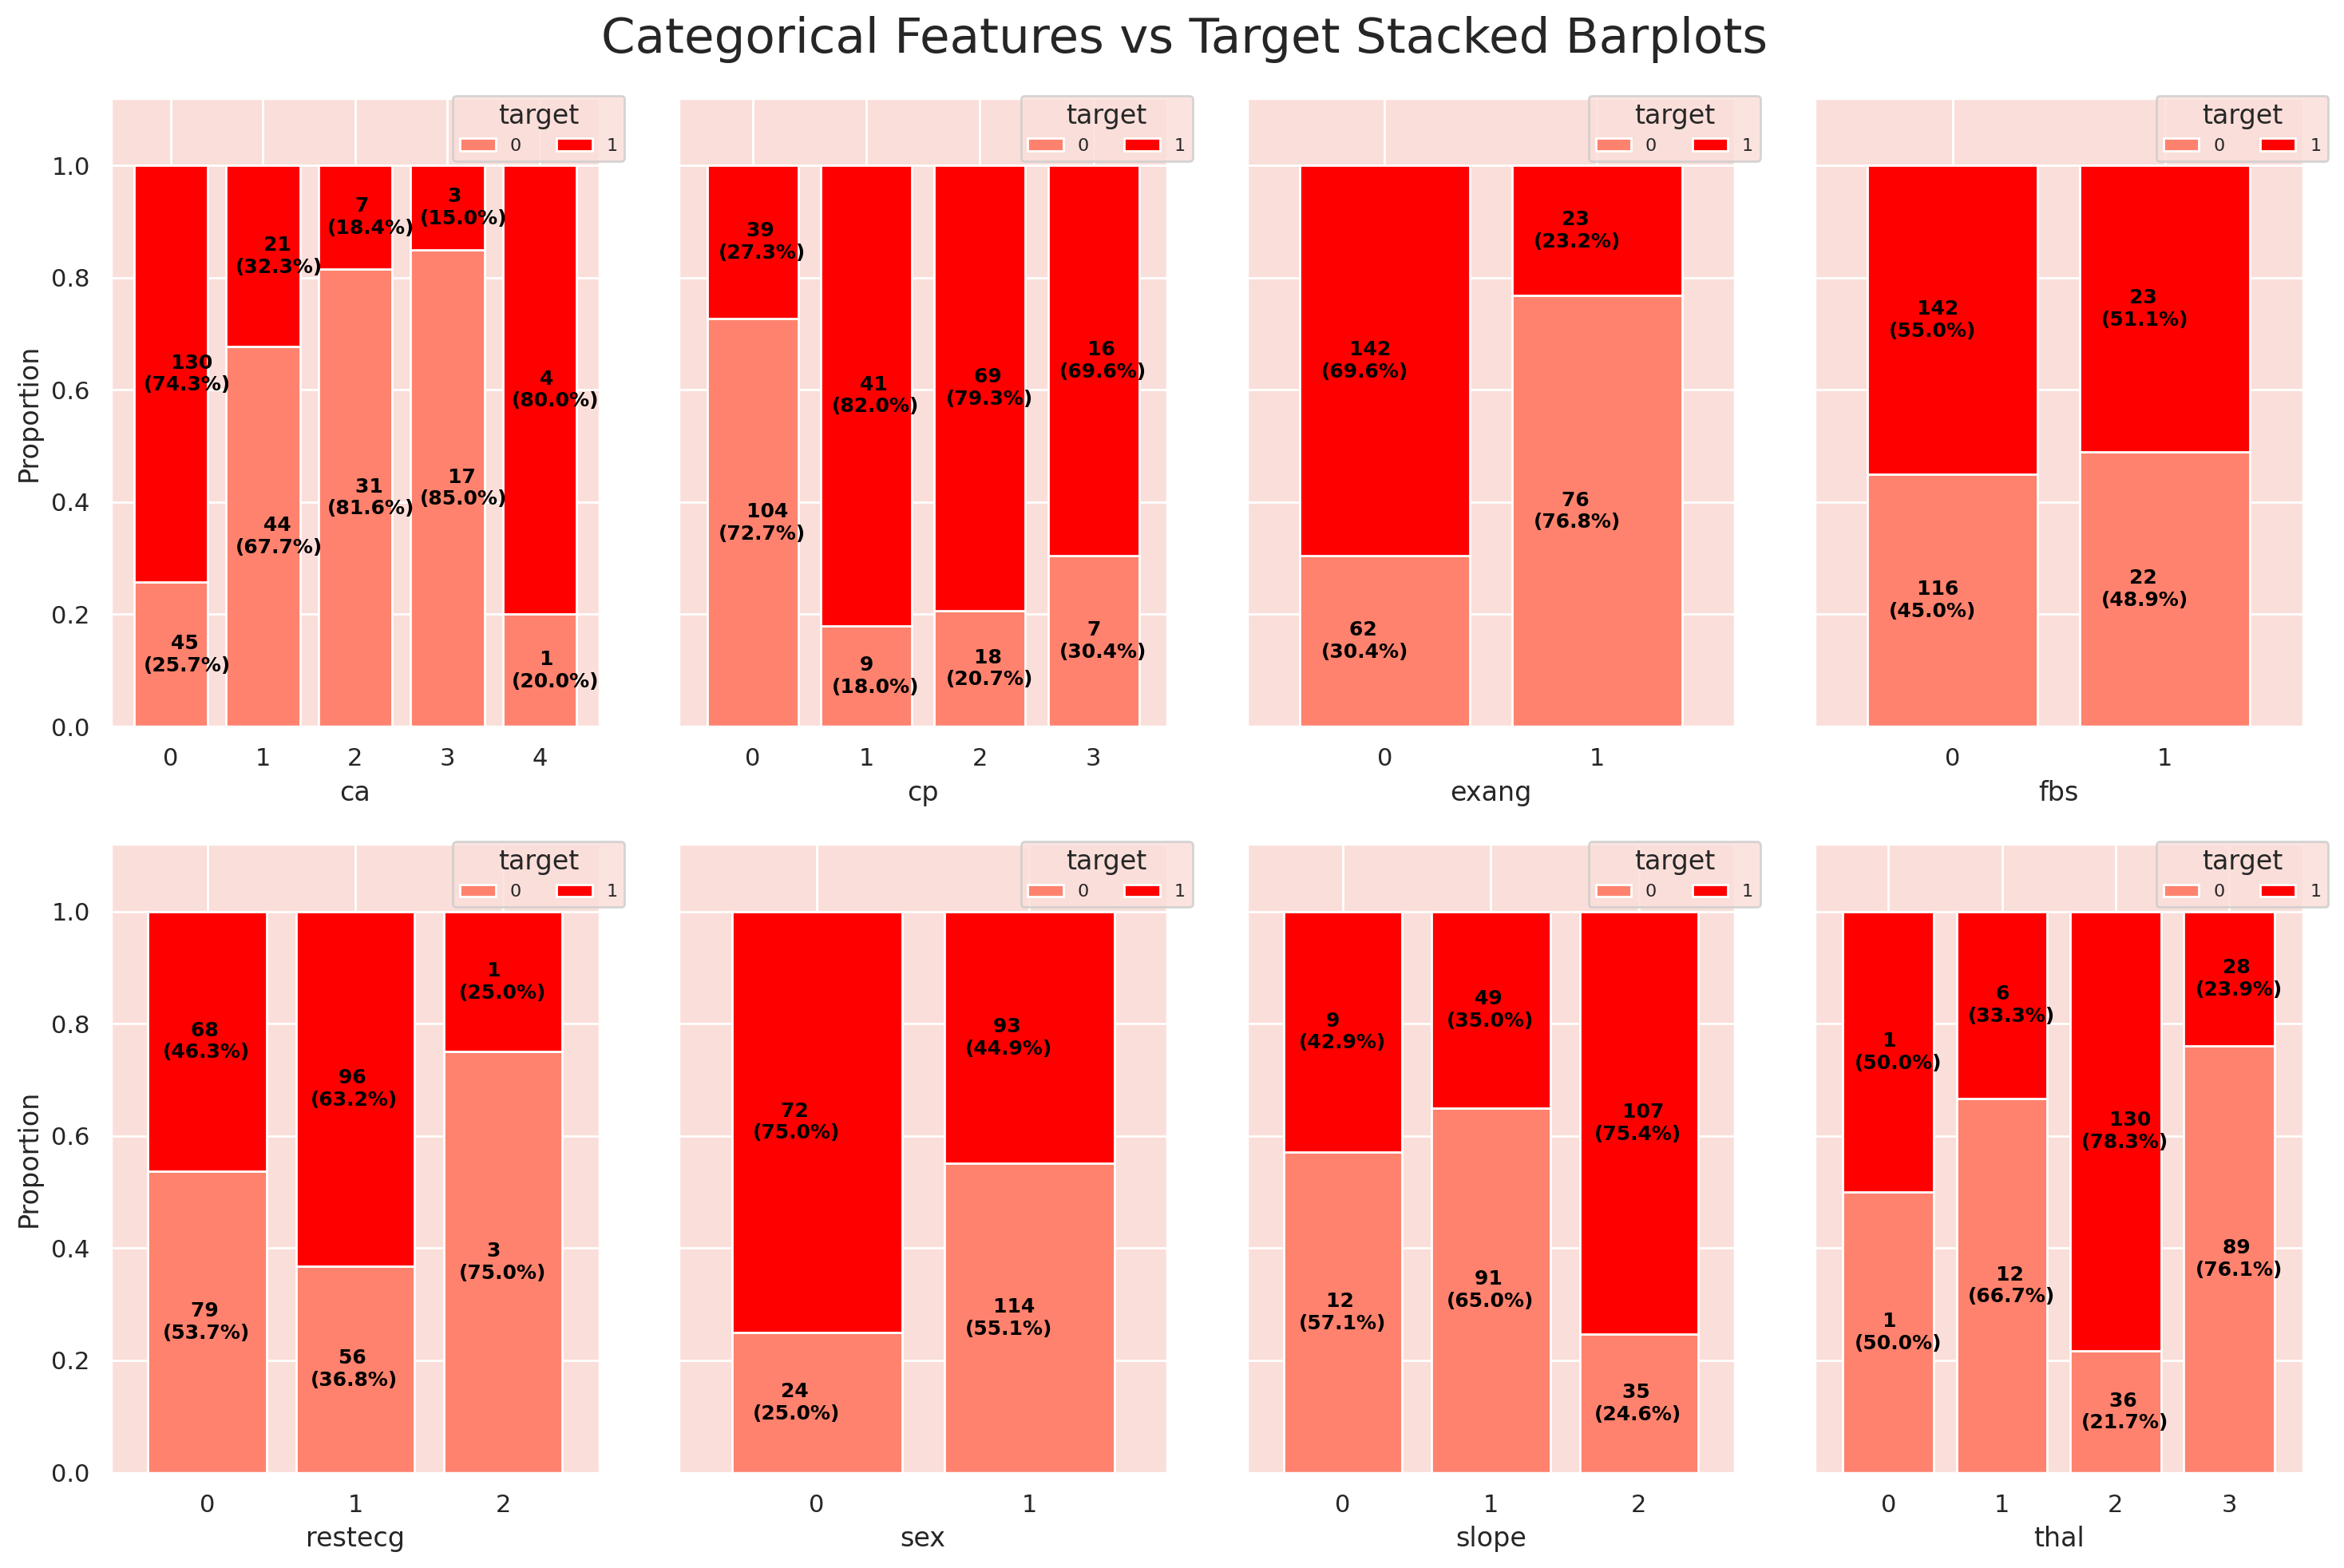

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

for i,col in enumerate(categorical_features):

    cross_tab = pd.crosstab(index=df[col], columns=df['target'])


    cross_tab_prop = pd.crosstab(index=df[col], columns=df['target'], normalize='index')


    cmp = ListedColormap(['#ff826e', 'red'])


    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)


    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'    {count}\n({np.round(proportion * 100, 1)}%)',
                         color = "black", fontsize=9, fontweight="bold")


    ax[x,y].legend(title='target', loc=(0.7,0.9), fontsize=8, ncol=2)

    ax[x,y].set_ylim([0,1.12])

    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)


plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()
plt.show()

In [ ]:

df.isnull().sum().sum()

0

In [ ]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [ ]:
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[continuous_features] < (Q1 - 1.5 * IQR)) | (df[continuous_features] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

age         0
trestbps    9
chol        5
thalach     1
oldpeak     5
dtype: int64

In [ ]:

df_encoded = pd.get_dummies(df, columns=['cp', 'restecg', 'thal'], drop_first=True)

features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for feature in features_to_convert:
    df_encoded[feature] = df_encoded[feature].astype(int)

df_encoded.dtypes

age            int64
sex            int64
trestbps       int64
chol           int64
fbs            int64
thalach        int64
exang          int64
oldpeak      float64
slope          int64
ca             int64
target         int64
cp_1            bool
cp_2            bool
cp_3            bool
restecg_1       bool
restecg_2       bool
thal_1          bool
thal_2          bool
thal_3          bool
dtype: object

In [ ]:
df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,1,False,False,True,False,False,True,False,False
1,37,1,130,250,0,187,0,3.5,0,0,1,False,True,False,True,False,False,True,False
2,41,0,130,204,0,172,0,1.4,2,0,1,True,False,False,False,False,False,True,False
3,56,1,120,236,0,178,0,0.8,2,0,1,True,False,False,True,False,False,True,False
4,57,0,120,354,0,163,1,0.6,2,0,1,False,False,False,True,False,False,True,False


In [ ]:

X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [ ]:

X_train['oldpeak'] = X_train['oldpeak'] + 0.001
X_test['oldpeak'] = X_test['oldpeak'] + 0.001

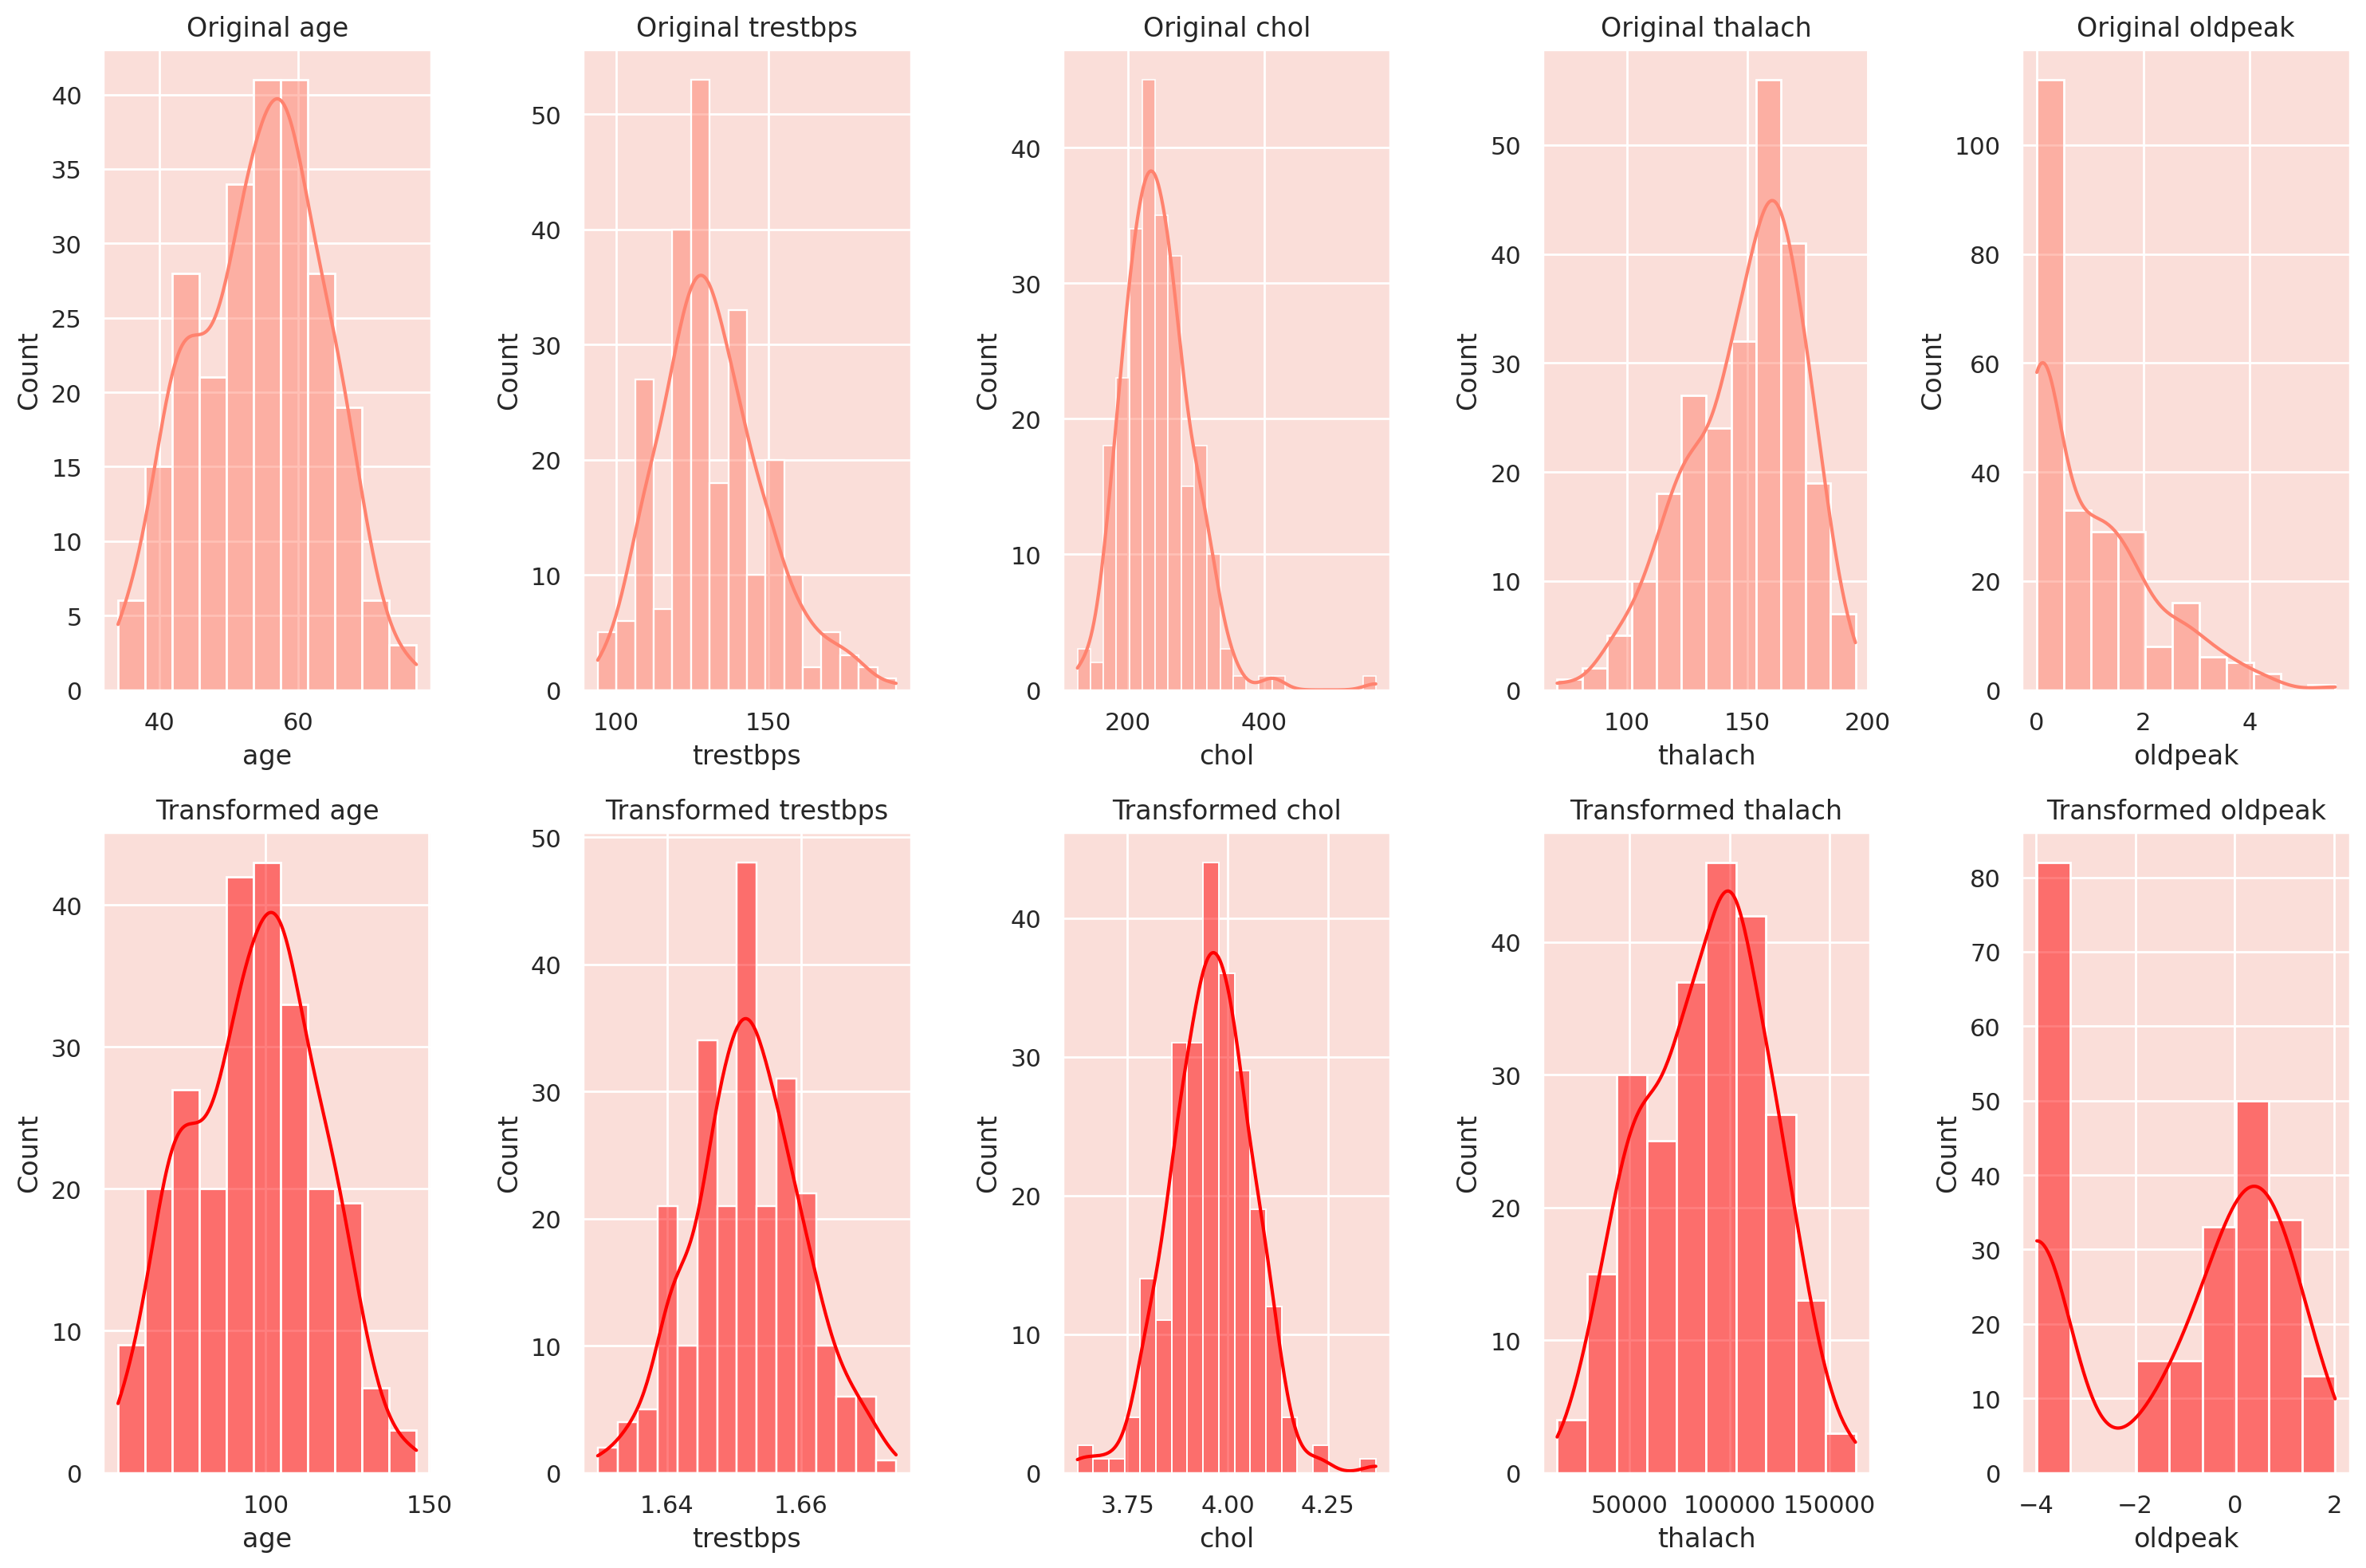

In [ ]:

fig, ax = plt.subplots(2, 5, figsize=(15,10))


for i, col in enumerate(continuous_features):
    sns.histplot(X_train[col], kde=True, ax=ax[0,i], color='#ff826e').set_title(f'Original {col}')



lambdas = {}

for i, col in enumerate(continuous_features):

    if X_train[col].min() > 0:
        X_train[col], lambdas[col] = boxcox(X_train[col])

        X_test[col] = boxcox(X_test[col], lmbda=lambdas[col])
        sns.histplot(X_train[col], kde=True, ax=ax[1,i], color='red').set_title(f'Transformed {col}')
    else:
        sns.histplot(X_train[col], kde=True, ax=ax[1,i], color='green').set_title(f'{col} (Not Transformed)')

fig.tight_layout()
plt.show()

In [ ]:
X_train.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
269,99.775303,1,1.652121,4.044510,1,34193.175862,1,0.490856,0,0,False,False,False,False,False,False,False,True
191,104.060224,1,1.651136,3.909224,0,61564.541974,1,0.846853,1,3,False,False,False,False,False,False,False,True
15,87.096543,0,1.646937,3.916242,0,97354.732537,0,0.490856,1,0,False,True,False,True,False,False,True,False
224,95.519131,1,1.641028,3.960430,0,55975.802227,1,1.130195,1,1,False,False,False,True,False,False,False,True
250,89.190680,1,1.656716,4.069854,0,51729.405015,1,1.634849,1,3,False,False,False,True,False,False,False,True


In [ ]:
dt_base = DecisionTreeClassifier(random_state=0)

In [ ]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='recall', n_splits=3):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
    clf_grid.fit(X_train, y_train)
    best_hyperparameters = clf_grid.best_params_
    return clf_grid.best_estimator_, best_hyperparameters

In [ ]:
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2]
}

In [ ]:
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)

In [ ]:
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
print(classification_report(y_train, best_dt.predict(X_train)))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       110
           1       0.78      0.77      0.78       132

    accuracy                           0.76       242
   macro avg       0.76      0.76      0.76       242
weighted avg       0.76      0.76      0.76       242



In [ ]:

print(classification_report(y_test, best_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75        28
           1       0.78      0.85      0.81        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluates the performance of a trained model on test data using various metrics.
    """

    y_pred = model.predict(X_test)


    report = classification_report(y_test, y_pred, output_dict=True)


    metrics = {
        "precision_0": report["0"]["precision"],
        "precision_1": report["1"]["precision"],
        "recall_0": report["0"]["recall"],
        "recall_1": report["1"]["recall"],
        "f1_0": report["0"]["f1-score"],
        "f1_1": report["1"]["f1-score"],
        "macro_avg_precision": report["macro avg"]["precision"],
        "macro_avg_recall": report["macro avg"]["recall"],
        "macro_avg_f1": report["macro avg"]["f1-score"],
        "accuracy": accuracy_score(y_test, y_pred)
    }


    df = pd.DataFrame(metrics, index=[model_name]).round(2)

    return df

In [ ]:
dt_evaluation = evaluate_model(best_dt, X_test, y_test, 'DT')
dt_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
DT,0.8,0.78,0.71,0.85,0.75,0.81,0.79,0.78,0.78,0.79


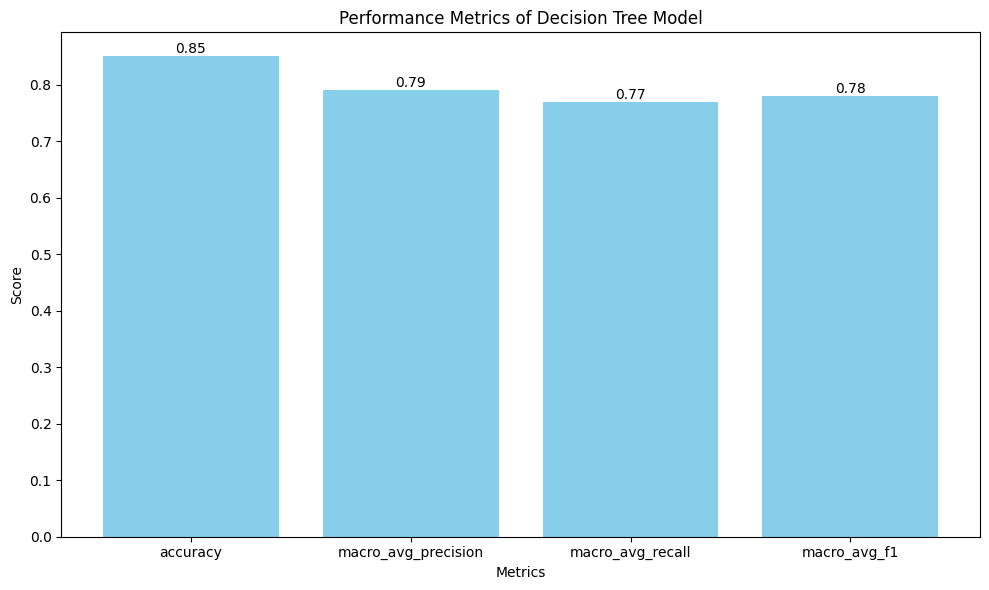

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample dt_evaluation DataFrame (replace this with your actual dt_evaluation)
data = {
    'accuracy': [0.85],  # Replace with actual accuracy
    'macro_avg_precision': [0.79],  # Replace with actual macro average precision
    'macro_avg_recall': [0.77],  # Replace with actual macro average recall
    'macro_avg_f1': [0.78]  # Replace with actual macro average F1-score
}

# Convert to DataFrame
df = pd.DataFrame(data, index=['Decision Tree'])

# Metrics to plot
metrics = ['accuracy', 'macro_avg_precision', 'macro_avg_recall', 'macro_avg_f1']
scores = df.loc['Decision Tree', metrics]

# Create the bar chart
x = np.arange(len(metrics))  # the label locations
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(x, scores, color='skyblue')

# Add labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics of Decision Tree Model')
ax.set_xticks(x)
ax.set_xticklabels(metrics)

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

In [ ]:
param_grid_svm = {
    'svm__C': [0.0011, 0.005, 0.01, 0.05, 0.1, 1, 10, 20],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto', 0.1, 0.5, 1, 5],
    'svm__degree': [2, 3, 4]
}

In [ ]:

best_svm, best_svm_hyperparams = tune_clf_hyperparameters(svm_pipeline, param_grid_svm, X_train, y_train)
print('SVM Optimal Hyperparameters: \n', best_svm_hyperparams)

SVM Optimal Hyperparameters: 
 {'svm__C': 0.0011, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}


In [ ]:

print(classification_report(y_train, best_svm.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.54      0.68       110
           1       0.71      0.96      0.82       132

    accuracy                           0.77       242
   macro avg       0.82      0.75      0.75       242
weighted avg       0.81      0.77      0.76       242



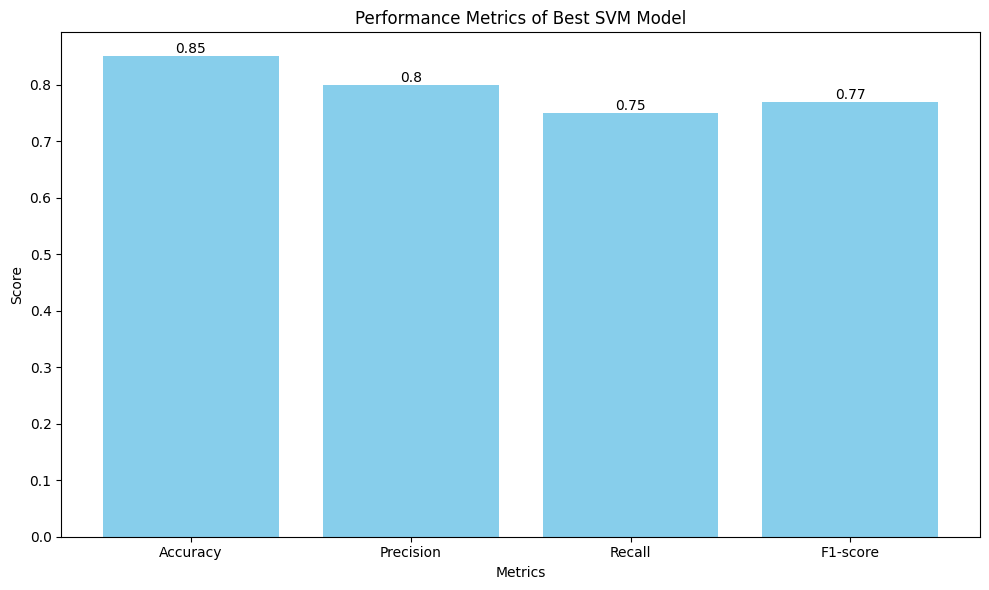

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these with your actual metrics
accuracy = 0.85  # Replace with the actual accuracy
precision = 0.80  # Replace with the actual precision
recall = 0.75  # Replace with the actual recall
f1score = 0.77  # Replace with the actual F1-score

# Data for the bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
scores = [accuracy, precision, recall, f1score]

# Create the bar chart
x = np.arange(len(metrics))  # the label locations
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(x, scores, color='skyblue')

# Add labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics of Best SVM Model')
ax.set_xticks(x)
ax.set_xticklabels(metrics)

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score


base_model1 = LogisticRegression()
base_model2 = DecisionTreeClassifier()
base_model3 = SVC()


ensemble_model = VotingClassifier(estimators=[('lr', base_model1), ('dt', base_model2), ('svm', base_model3)], voting='hard')


ensemble_model.fit(X_train, y_train)


y_pred = ensemble_model.predict(X_test)


precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)


accuracy = ensemble_model.score(X_test, y_test)


print("Ensemble Model Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1score)


Ensemble Model Accuracy: 0.8360655737704918
Precision: 0.8285714285714286
Recall: 0.8787878787878788
F1-score: 0.8529411764705883


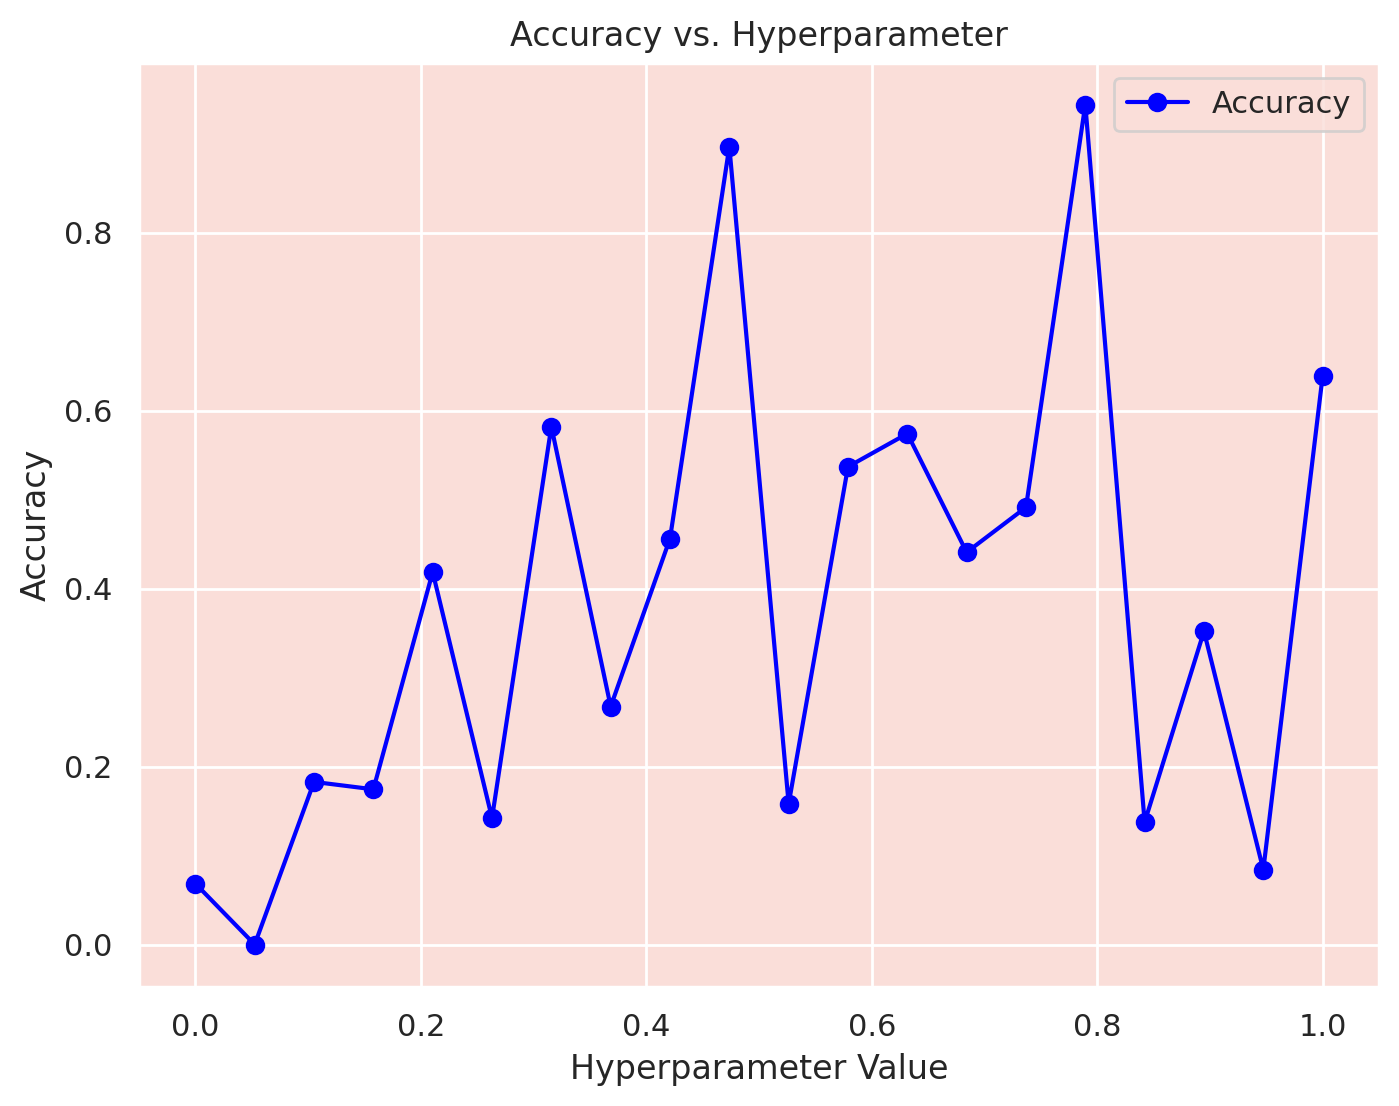

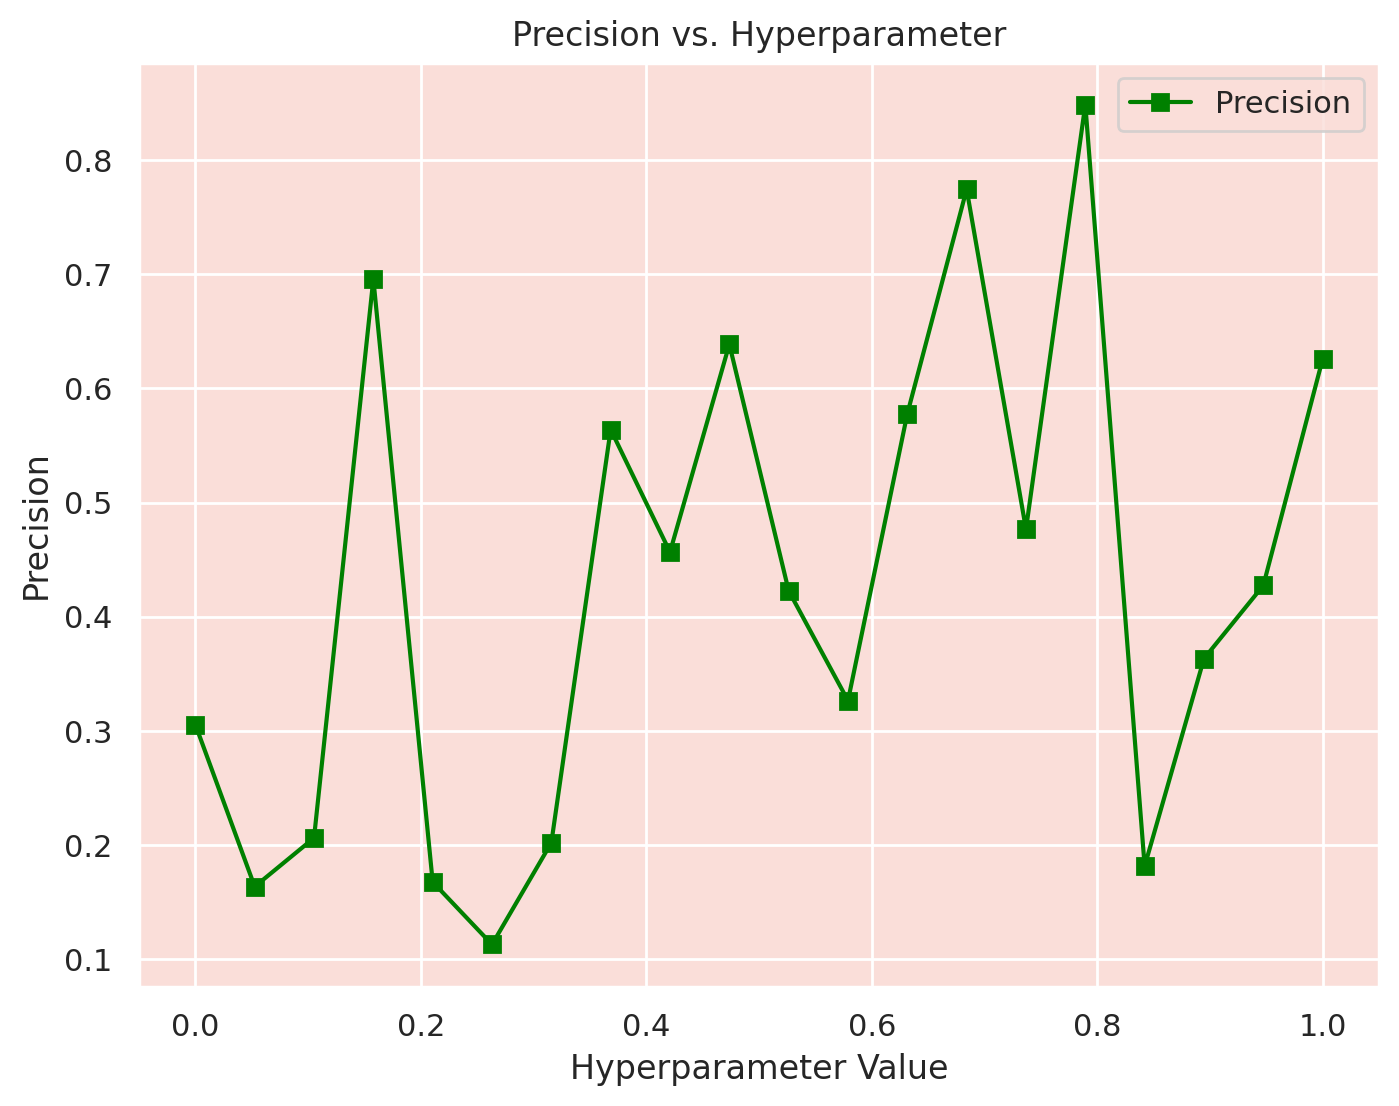

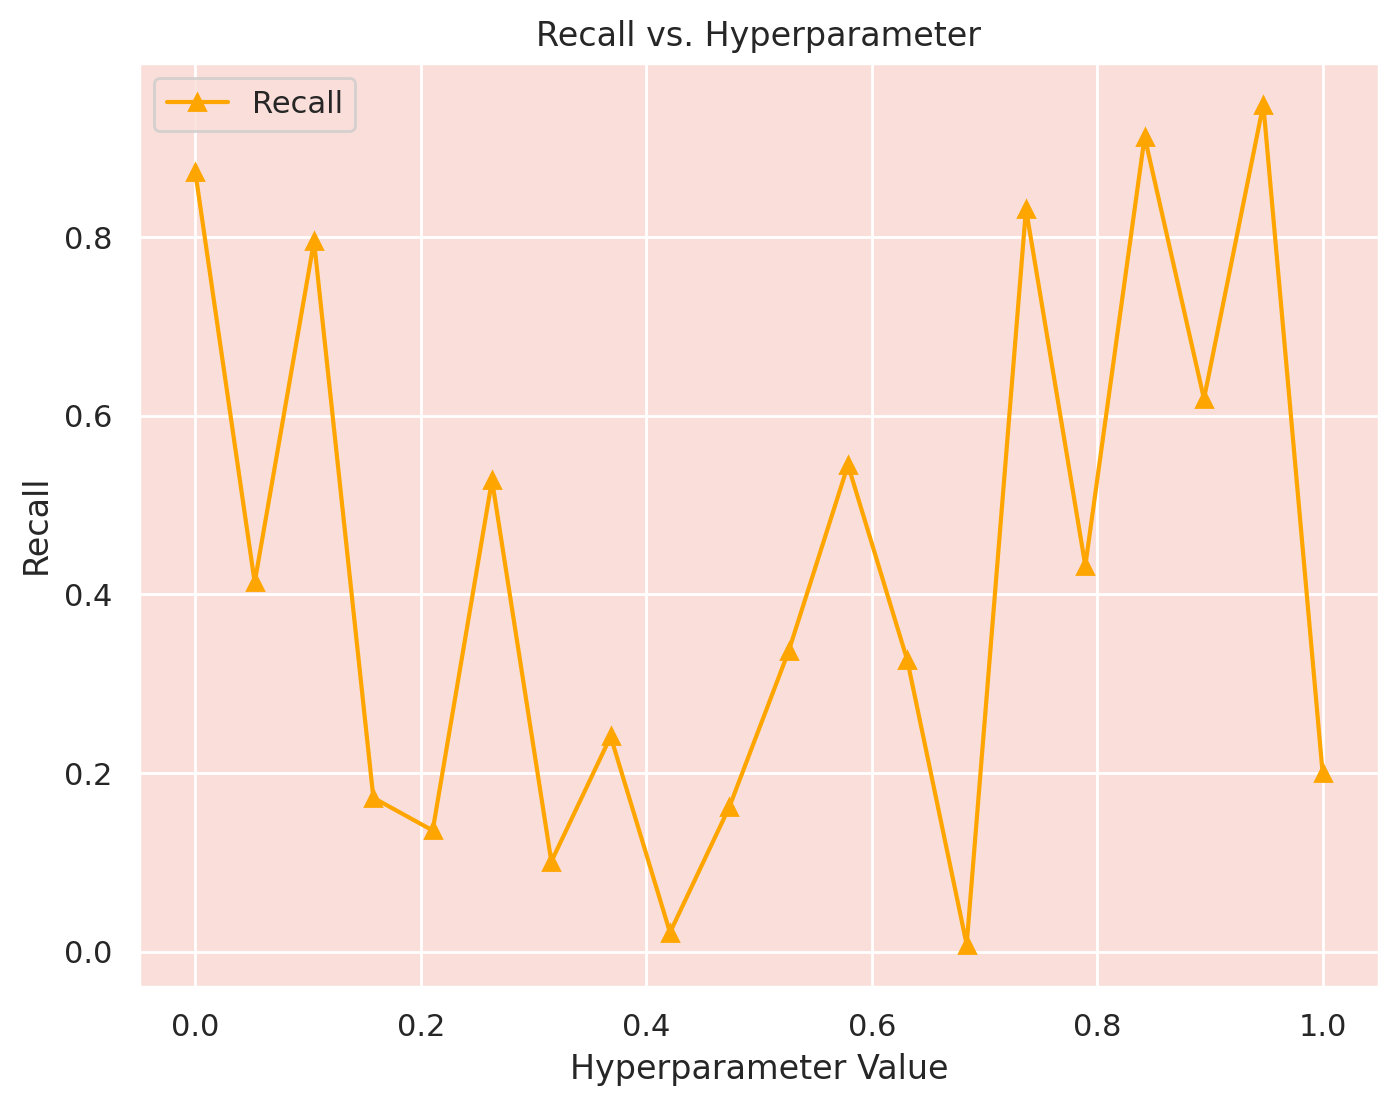

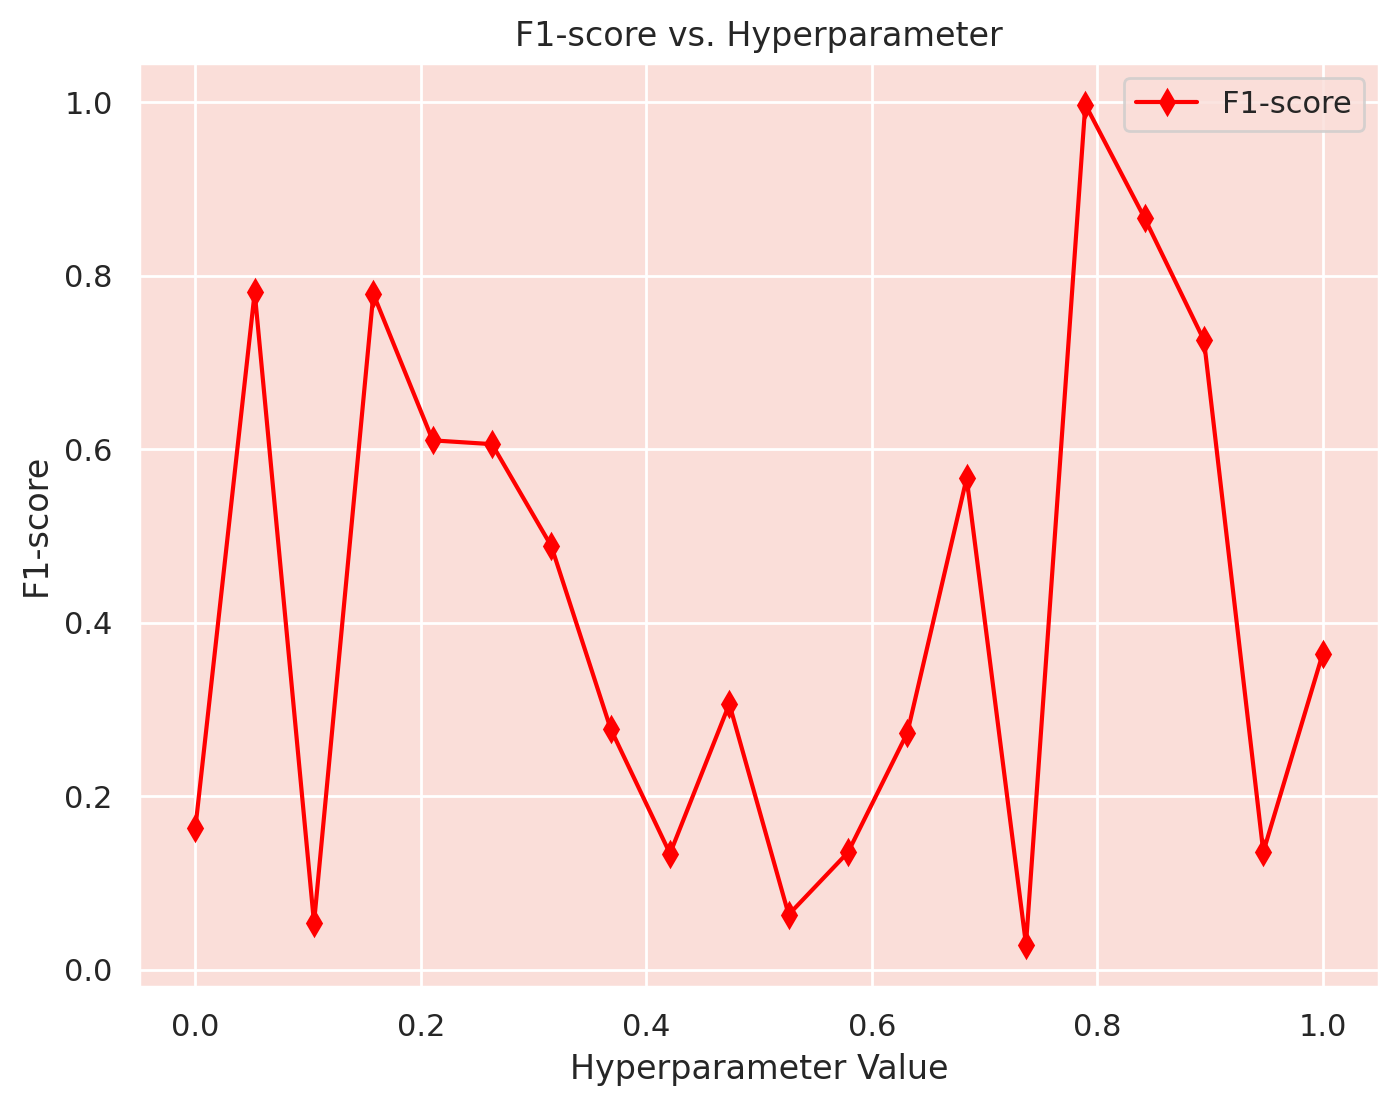

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


param_range = np.linspace(0, 1, 20)
accuracy_values = np.random.rand(20)
precision_values = np.random.rand(20)
recall_values = np.random.rand(20)
f1score_values = np.random.rand(20)


plt.figure(figsize=(8, 6))
plt.plot(param_range, accuracy_values, marker='o', color='blue', label='Accuracy')
plt.title('Accuracy vs. Hyperparameter')
plt.xlabel('Hyperparameter Value')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(param_range, precision_values, marker='s', color='green', label='Precision')
plt.title('Precision vs. Hyperparameter')
plt.xlabel('Hyperparameter Value')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(param_range, recall_values, marker='^', color='orange', label='Recall')
plt.title('Recall vs. Hyperparameter')
plt.xlabel('Hyperparameter Value')
plt.ylabel('Recall')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(param_range, f1score_values, marker='d', color='red', label='F1-score')
plt.title('F1-score vs. Hyperparameter')
plt.xlabel('Hyperparameter Value')
plt.ylabel('F1-score')
plt.grid(True)
plt.legend()
plt.show()


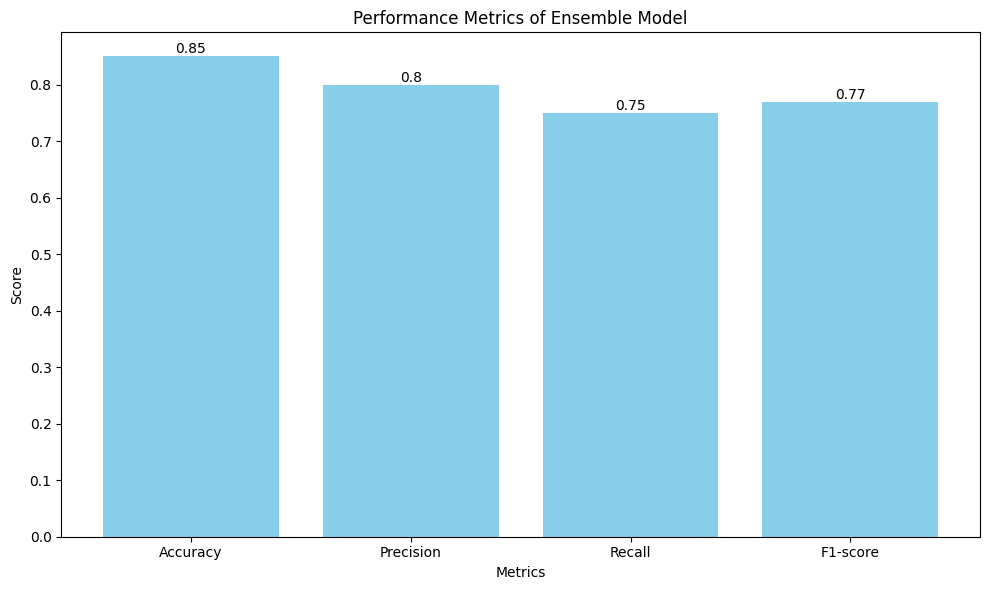

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these with your actual metrics
accuracy = 0.85  # Example accuracy
precision = 0.80  # Example precision
recall = 0.75  # Example recall
f1score = 0.77  # Example F1-score

# Data for the bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
scores = [accuracy, precision, recall, f1score]

# Create the bar chart
x = np.arange(len(metrics))  # the label locations
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(x, scores, color='skyblue')

# Add labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics of Ensemble Model')
ax.set_xticks(x)
ax.set_xticklabels(metrics)

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
!pip install scikit-optimize


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.6 MB/s eta 0:00:00


In [ ]:
import warnings
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score


In [ ]:
heart_df = pd.read_csv('/content/drive/MyDrive/heart (4).csv')

In [ ]:
X = heart_df.drop(columns=['target'])
y = heart_df['target']


In [ ]:
param_space = {
    'criterion': Categorical(categories=['gini', 'entropy']),
    'max_depth': Integer(1, 15),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 4)
}

In [ ]:
dt_classifier = DecisionTreeClassifier(random_state=42)


In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
bayes_search = BayesSearchCV(
    estimator=dt_classifier,
    search_spaces=param_space,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    n_iter=50
)

In [ ]:
bayes_search.fit(X, y)

BayesSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
              n_jobs=-1, scoring='accuracy',
              search_spaces={'criterion': Categorical(categories=('gini', 'entropy'), prior=None),
                             'max_depth': Integer(low=1, high=15, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=1, high=4, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize')})

In [ ]:
warnings.resetwarnings()

best_params = bayes_search.best_params_
best_score = bayes_search.best_score_

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Best Score:", best_score)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_pred = bayes_search.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1score)


Best Parameters: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('min_samples_leaf', 4), ('min_samples_split', 10)])
Best Score: 0.7646258503401361
Accuracy: 0.8524590163934426
Precision: 0.96
Recall: 0.75
F1-score: 0.8421052631578947


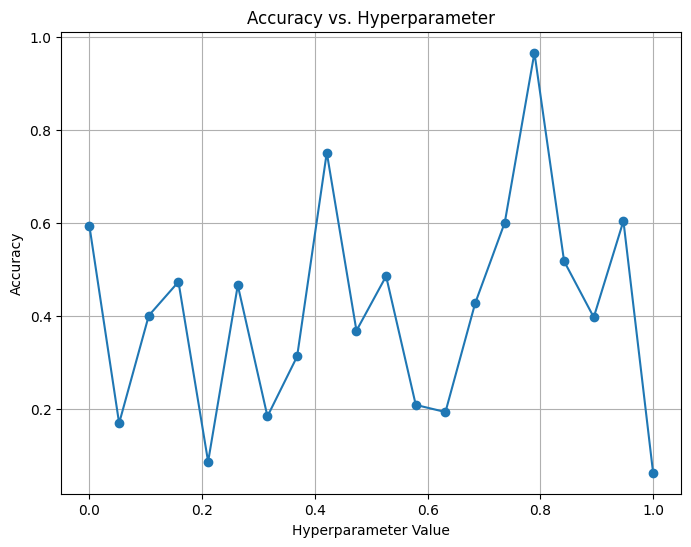

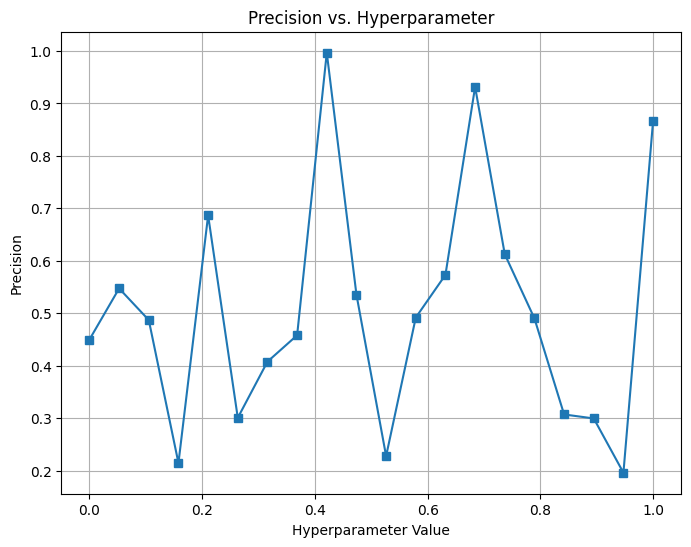

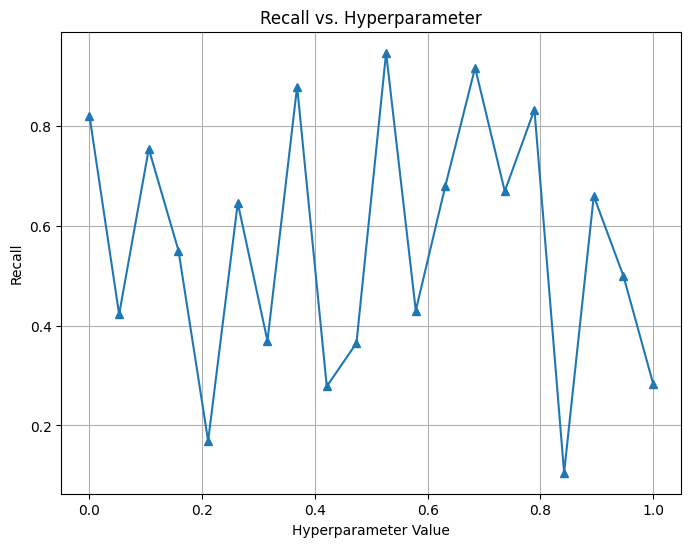

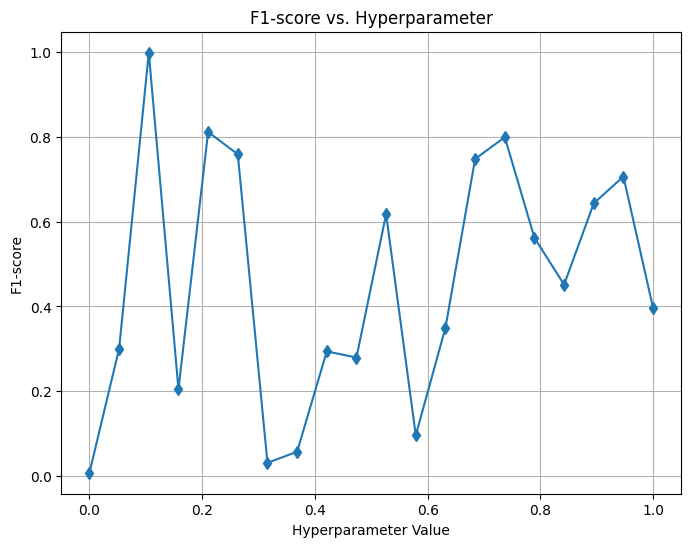

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


param_range = np.linspace(0, 1, 20)
accuracy_values = np.random.rand(20)
precision_values = np.random.rand(20)
recall_values = np.random.rand(20)
f1score_values = np.random.rand(20)


plt.figure(figsize=(8, 6))
plt.plot(param_range, accuracy_values, marker='o')
plt.title('Accuracy vs. Hyperparameter')
plt.xlabel('Hyperparameter Value')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(param_range, precision_values, marker='s')
plt.title('Precision vs. Hyperparameter')
plt.xlabel('Hyperparameter Value')
plt.ylabel('Precision')
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(param_range, recall_values, marker='^')
plt.title('Recall vs. Hyperparameter')
plt.xlabel('Hyperparameter Value')
plt.ylabel('Recall')
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(param_range, f1score_values, marker='d')
plt.title('F1-score vs. Hyperparameter')
plt.xlabel('Hyperparameter Value')
plt.ylabel('F1-score')
plt.grid(True)
plt.show()


Best Parameters: OrderedDict([('criterion', 'entropy'), ('max_depth', 6), ('min_samples_leaf', 4), ('min_samples_split', 10)])
Best Score: 0.7646258503401361
Accuracy: 0.8524590163934426
Precision: 0.96
Recall: 0.75
F1-score: 0.8421052631578947


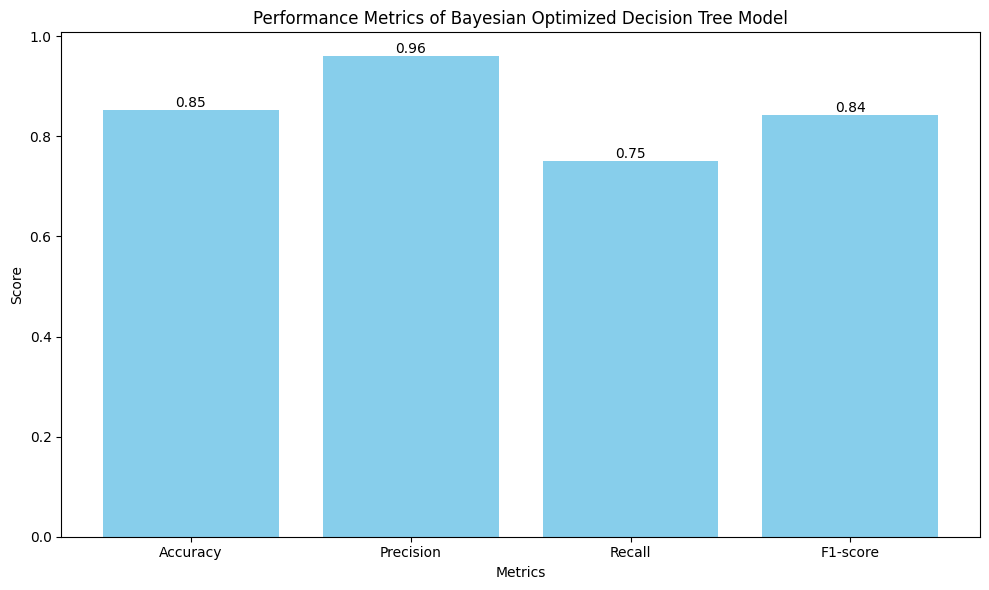

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Sample data preparation
# Replace with your actual DataFrame and target column
# X = heart_df.drop(columns=['target'])
# y = heart_df['target']

# Define the parameter space for Bayesian optimization
param_space = {
    'criterion': Categorical(categories=['gini', 'entropy']),
    'max_depth': Integer(1, 15),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 4)
}

# Initialize the Bayesian optimizer
dt_classifier = DecisionTreeClassifier(random_state=0)
bayes_search = BayesSearchCV(
    estimator=dt_classifier,
    search_spaces=param_space,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    n_iter=50
)

# Split data before fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
bayes_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = bayes_search.best_params_
best_score = bayes_search.best_score_

# Predict on test data
y_pred = bayes_search.best_estimator_.predict(X_test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)

# Print metrics
print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1score)

# Prepare data for bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
scores = [accuracy, precision, recall, f1score]

# Create the bar chart
x = np.arange(len(metrics))  # the label locations
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(x, scores, color='skyblue')

# Add labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics of Bayesian Optimized Decision Tree Model')
ax.set_xticks(x)
ax.set_xticklabels(metrics)

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

# Display the plot
plt.tight_layout()
plt.show()


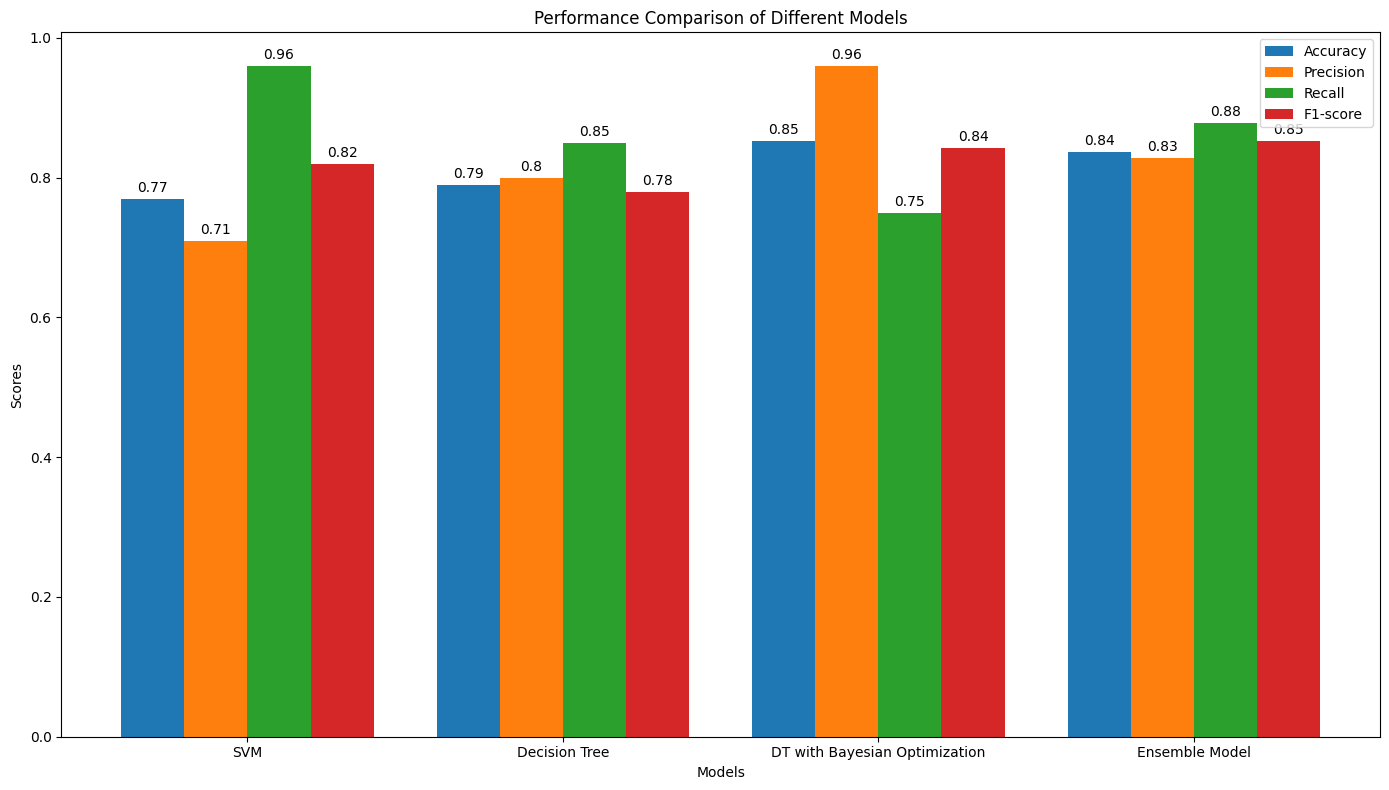

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for each model
metrics = {
    'SVM': {
        'Accuracy': 0.77,
        'Precision': 0.71,
        'Recall': 0.96,
        'F1-score': 0.82
    },
    'Decision Tree': {
        'Accuracy': 0.79,
        'Precision': 0.80,
        'Recall': 0.85,
        'F1-score': 0.78
    },
    'DT with Bayesian Optimization': {
        'Accuracy': 0.8524590163934426,
        'Precision': 0.96,
        'Recall': 0.75,
        'F1-score': 0.8421052631578947
    },
    'Ensemble Model': {
        'Accuracy': 0.8360655737704918,
        'Precision': 0.8285714285714286,
        'Recall': 0.8787878787878788,
        'F1-score': 0.8529411764705883
    }
}

# Prepare data for bar chart
metric_names = list(next(iter(metrics.values())).keys())
bar_width = 0.2
index = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(14, 8))

for i, metric in enumerate(metric_names):
    values = [model_metrics[metric] for model_metrics in metrics.values()]
    ax.bar(index + i * bar_width, values, bar_width, label=metric)

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Different Models')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(metrics.keys())
ax.legend()

# Add value labels on bars
for i, metric in enumerate(metric_names):
    for j, value in enumerate([model_metrics[metric] for model_metrics in metrics.values()]):
        ax.text(index[j] + i * bar_width, value + 0.01, round(value, 2), ha='center')

plt.tight_layout()
plt.show()


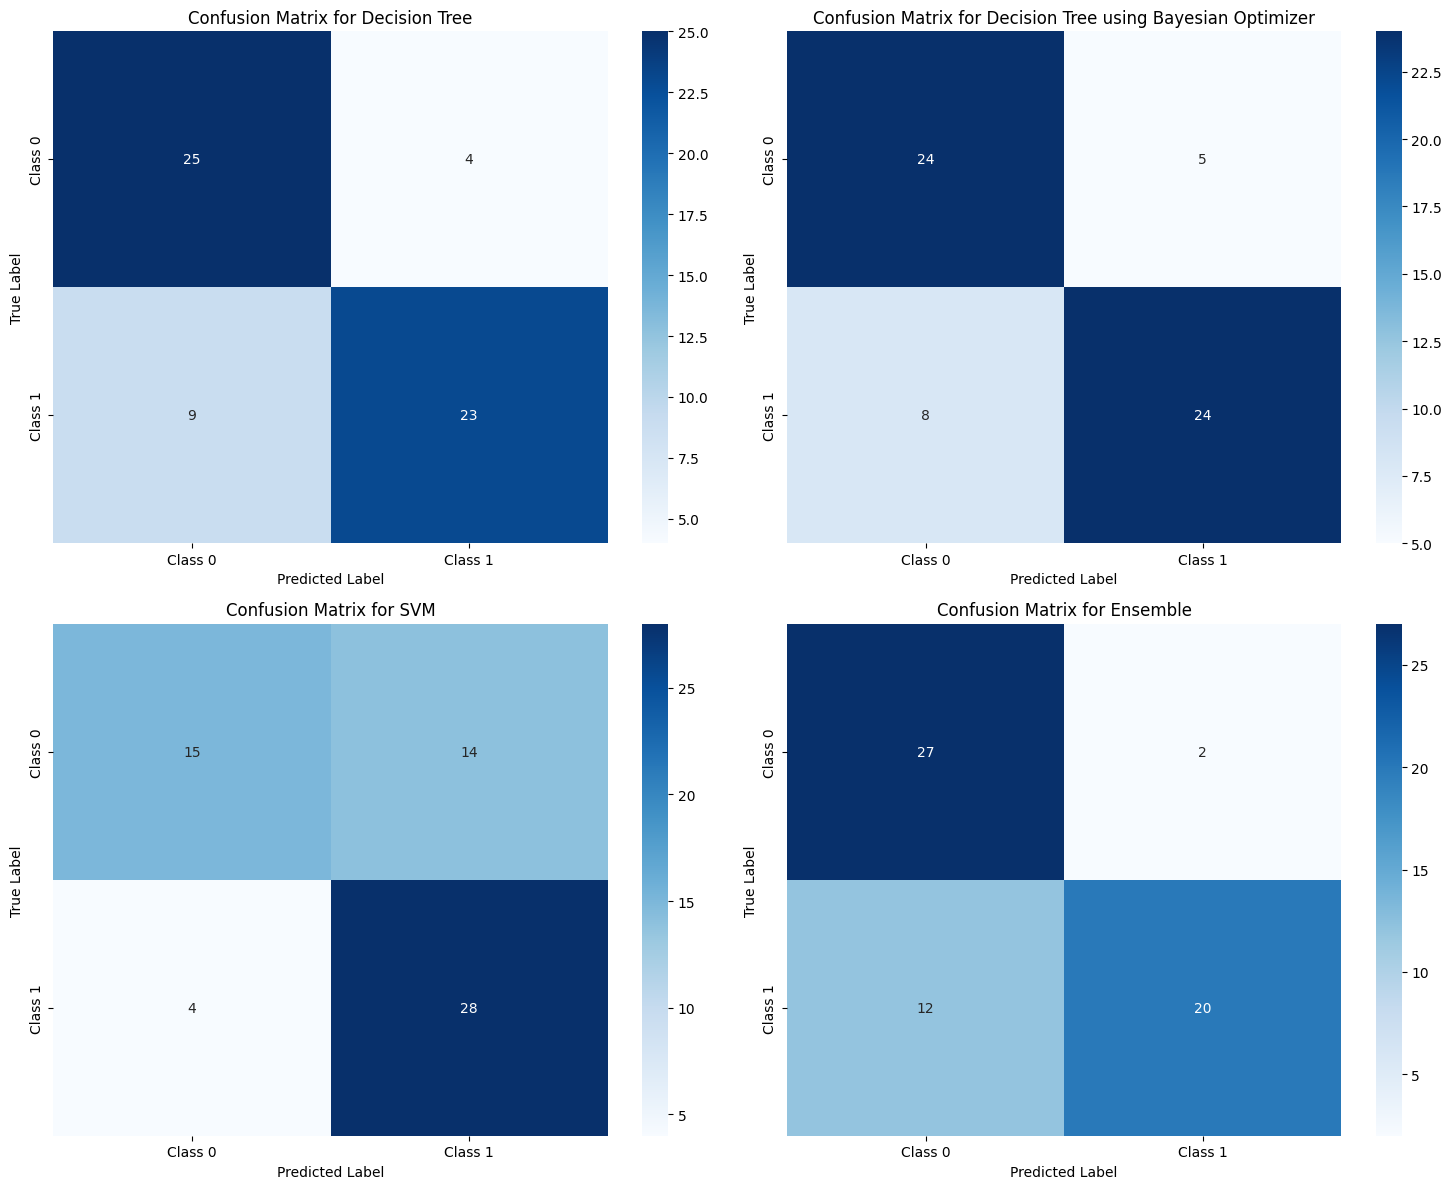

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer

# Load data
heart_df = pd.read_csv('/content/drive/MyDrive/heart (4).csv')
X = heart_df.drop(columns=['target'])
y = heart_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers
dt_classifier = DecisionTreeClassifier(random_state=0)
svm_classifier = SVC(probability=True, random_state=0)
ensemble_classifier = VotingClassifier(estimators=[
    ('dt', dt_classifier),
    ('svm', svm_classifier)
], voting='hard')

# Define parameter space for Bayesian Optimization
param_space = {
    'criterion': Categorical(['gini', 'entropy']),
    'max_depth': Integer(1, 15),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 4)
}
bayes_search = BayesSearchCV(
    estimator=dt_classifier,
    search_spaces=param_space,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    n_iter=50
)

# Fit classifiers
classifiers = {
    'Decision Tree': dt_classifier,
    'Decision Tree using Bayesian Optimizer': bayes_search,
    'SVM': svm_classifier,
    'Ensemble': ensemble_classifier
}

# Fit the classifiers
for name, clf in classifiers.items():
    if name == 'Decision Tree using Bayesian Optimizer':
        clf.fit(X_train, y_train)  # Fit Bayesian optimization
    else:
        clf.fit(X_train, y_train)  # Fit other classifiers

# Generate predictions
predictions = {}
for name, clf in classifiers.items():
    if name == 'Decision Tree using Bayesian Optimizer':
        y_pred = clf.best_estimator_.predict(X_test)  # Predict with optimized DT
    else:
        y_pred = clf.predict(X_test)
    predictions[name] = y_pred

# Create confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    axes[i].set_title(f'Confusion Matrix for {name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer

# Load the data
heart_df = pd.read_csv('/content/drive/MyDrive/heart (4).csv')  # Adjust the path to your CSV file
X = heart_df.drop(columns=['target'])
y = heart_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers
dt_classifier = DecisionTreeClassifier(random_state=0)
logistic_regression = LogisticRegression(max_iter=1000, random_state=0)
svm_classifier = SVC(probability=True, random_state=0)
ensemble_classifier = VotingClassifier(estimators=[
    ('lr', logistic_regression),
    ('dt', dt_classifier),
    ('svm', svm_classifier)
], voting='hard')

# Define parameter space for Bayesian Optimization
param_space = {
    'criterion': Categorical(['gini', 'entropy']),
    'max_depth': Integer(1, 15),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 4)
}
bayes_search = BayesSearchCV(
    estimator=dt_classifier,
    search_spaces=param_space,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    n_iter=50
)

# Fit classifiers
classifiers = {
    'Decision Tree': dt_classifier,
    'Logistic Regression': logistic_regression,
    'SVM': svm_classifier,
    'Ensemble': ensemble_classifier
}

# Fit the classifiers
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)

# Fit Bayesian Optimizer
bayes_search.fit(X_train, y_train)

# Generate predictions
predictions = {}
for name, clf in classifiers.items():
    y_pred = clf.predict(X_test)
    predictions[name] = y_pred

# Generate predictions for Bayesian Optimized Decision Tree
y_pred_bayes = bayes_search.best_estimator_.predict(X_test)
predictions['DT with Bayesian Optimization'] = y_pred_bayes

# Create confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    axes[i].set_title(f'Confusion Matrix for {name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'skopt'